In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')
deaths =deaths.loc[deaths['Population']!=0]



#confirmed.head()

In [3]:
def make_us_population():
    df = pd.DataFrame()
    df['State']= deaths['Province_State'].values
    df['County'] = deaths['Admin2'].values
    df['Population']= deaths['Population'].values
    df.to_excel('US_Counties_Population.xlsx')
    return df


In [4]:
def get_pop100k(state, county):
    pop_df = pd.read_csv('UID_ISO_FIPS_LookUp_Table.csv')
    pop_df= pop_df.loc[pop_df['Country_Region']=='US']
    pop_df.rename(columns ={'Admin2':'County'} , inplace = True)
    pop_df= pop_df.loc[pop_df['Province_State']== state]
    pop_df = pop_df.loc[pop_df['County']==county]
    population = pop_df['Population'].values
    pop100k = population / 100000
    return pop100k


In [5]:
def make_state_df(df, state):
    state_df =df.loc[df['Province_State']==state]
    state_df.rename(columns={'Admin2':'County'}, inplace=True)
    
    return state_df  
   
ny_confirm = make_state_df(confirmed,'New York')
ny_death = make_state_df(deaths, 'New York')
#ny_confirm.head()

In [6]:
def make_county_confirmed (state_df, county):
    county_df =state_df.loc[state_df['County']==county]
    county_df= county_df.iloc[:,11:]
    
    return county_df

def make_county_deaths (state_deaths, county):
    county_df =state_deaths.loc[state_deaths['County']==county]
    county_df= county_df.iloc[:,12:]
    

   
    #population =county_pop['Population'].value
    
    # county_pop, population
    return county_df
def county_population(state_deaths, county):
    county_df =state_deaths.loc[state_deaths['County']==county]
    
    county_pop= county_df['Population'].values   
    return county_pop
#county_df = make_county_confir

In [7]:
def make_new_cases(county_df):
    county_values = county_df.T.values
    
    ei = county_df.T.index.values
    ei
    x=0
    new_cases=[]
    for case in county_values:
        if(x==0):
            new_cases.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_cases)
            nc= case - current
            if(case > current):
                    
                    new_cases.append(nc)
            else:
                new_cases.append(0)
           
            y=y+1
    return new_cases
    
         


In [8]:
def make_rolling_average(df):    
    days_1ago= df['New_Cases'].shift(1).fillna(method='backfill')
    days_2ago = df['New_Cases'].shift(2).fillna(method='backfill')
    days_3ago = df['New_Cases'].shift(3).fillna(method='backfill')
    days_4ago = df['New_Cases'].shift(4).fillna(method='backfill')
    days_5ago = df['New_Cases'].shift(5).fillna(method='backfill')
    today = df['New_Cases']

    df['Average'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    return df['Average']


In [9]:
def make_rolling_death(df):    
    days_1ago= df['New_Deaths'].shift(1).fillna(method='backfill')
    days_2ago = df['New_Deaths'].shift(2).fillna(method='backfill')
    days_3ago = df['New_Deaths'].shift(3).fillna(method='backfill')
    days_4ago = df['New_Deaths'].shift(4).fillna(method='backfill')
    days_5ago = df['New_Deaths'].shift(5).fillna(method='backfill')
    today = df['New_Deaths']

    df['Average_Deaths'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    return df['Average_Deaths']


In [10]:
def past_2_weeks(df):
    today = df['New_Cases']
    days_1ago= df['New_Cases'].shift(1).fillna(method='backfill')
    days_2ago = df['New_Cases'].shift(2).fillna(method='backfill')
    days_3ago = df['New_Cases'].shift(3).fillna(method='backfill')
    days_4ago = df['New_Cases'].shift(4).fillna(method='backfill')
    days_5ago = df['New_Cases'].shift(5).fillna(method='backfill')
    days_6ago= df['New_Cases'].shift(6).fillna(method='backfill')
    days_7ago = df['New_Cases'].shift(7).fillna(method='backfill')
    days_8ago = df['New_Cases'].shift(8).fillna(method='backfill')
    days_9ago = df['New_Cases'].shift(9).fillna(method='backfill')
    days_10ago = df['New_Cases'].shift(10).fillna(method='backfill')
    days_11ago= df['New_Cases'].shift(11).fillna(method='backfill')
    days_12ago = df['New_Cases'].shift(12).fillna(method='backfill')
    days_13ago = df['New_Cases'].shift(13).fillna(method='backfill')
    df['New_Cases_2wks']= today + days_1ago +days_2ago +days_3ago+ days_4ago +days_5ago + days_6ago+ days_7ago +days_8ago+ days_9ago +days_10ago+days_11ago+days_12ago+days_13ago
    return df['New_Cases_2wks']

In [11]:
def join_tables(confirmed_df, death_df, daily_confirms, daily_deaths, county_pop):
    confirmed_df.index.name ='Confirmed'
    death_df.index.name = 'Deaths'
    
    c_trans = confirmed_df.T
    
    d_trans = death_df.T
   
    c_trans.index.name = 'Date'
    d_trans.index.name = 'Date'
   
    onehundredk = float(county_pop / 100000)
    death25k = float(county_pop/ 25000)
    joined_df = c_trans.join(d_trans,lsuffix='Date', rsuffix='Date')
    joined_df['Confirmed']= c_trans.values
    joined_df['Confirmed_per_100k']=joined_df['Confirmed']/ onehundredk
    joined_df['Deaths']= d_trans.values
    joined_df['Deaths_Per_25k']=joined_df['Deaths']/death25k
    joined_df['New_Cases']=daily_confirms
    joined_df['New_Deaths']= daily_deaths
    joined_df['Population_Affected']=  joined_df['Confirmed'] / county_pop
    joined_df['Average']= make_rolling_average(joined_df)
    joined_df['Average_Deaths']= make_rolling_death(joined_df)
    #joined_df.drop(['1914Date'],axis=1, inplace=True)
    onehundredk = float(county_pop / 100000)
    death25k = float(county_pop/ 25000)
    joined_df['Ave_per_100k'] = joined_df['Average']/ onehundredk
    
    joined_df['New_Cases_2wks'] = past_2_weeks(joined_df)
    joined_df['NC_2wks_per_100k'] = joined_df['New_Cases_2wks'] / onehundredk
    joined_df = joined_df.iloc[:, 2:]
    
    return joined_df


In [12]:
def id_columns (join_df, County , State):
    join_df['County']= County
    join_df['State'] = State 
    join_df['New_Cases']= join_df['New_Cases'].astype(int)
    join_df['New_Deaths'] = join_df['New_Deaths'].astype(int)
    join_df['Population_Affected']= join_df['Population_Affected'].round(5)
    join_df['Average'] = join_df['Average'].astype(int)
    join_df['Average_Deaths']= join_df['Average_Deaths'].astype(int)
    join_df['Ave_per_100k']= join_df['Ave_per_100k'].astype(int) 
    join_df['New_Cases_2wks'] = join_df['New_Cases_2wks'].astype(int)
    join_df['NC_2wks_per_100k'] = join_df['NC_2wks_per_100k'].astype(int) 
    join_df['State']= join_df['State'].astype(str)
    join_df['County']= join_df['County'].astype(str)
    join_df['Confirmed_per_100k']=join_df['Confirmed_per_100k'].astype(int)
    
    
    return join_df


In [13]:
def one_shot(County, State):
    state_confirmed= make_state_df(confirmed, State)
    state_deaths = make_state_df(deaths, State)
    county_df = make_county_confirmed(state_confirmed, County)
    county_dd = make_county_deaths(state_deaths, County)
    daily_confirms = make_new_cases(county_df)
    daily_deaths = make_new_cases (county_dd)
    county_pop = county_population(state_deaths, County)
    join_df = join_tables(county_df, county_dd, daily_confirms, daily_deaths, county_pop)
    df = id_columns(join_df, County, State)
    return df 


In [14]:
def one_shot_6_months(County, State):
    state_confirmed= make_state_df(confirmed, State)
    state_deaths = make_state_df(deaths, State)
    county_df = make_county_confirmed(state_confirmed, County)
    county_dd = make_county_deaths(state_deaths, County)
    daily_confirms = make_new_cases(county_df)
    daily_deaths = make_new_cases (county_dd)
    county_pop = county_population(state_deaths, County)
    join_df = join_tables(county_df, county_dd, daily_confirms, daily_deaths, county_pop)
    df = id_columns(join_df, County, State)
    n= df.shape[0]-180
    df = df.iloc[n:,:]
    return df 

In [15]:
erie = one_shot_6_months('Erie' , 'New York')
erie.tail(20)

Confirmed  Confirmed_per_100k  Deaths  Deaths_Per_25k  New_Cases  \
Date                                                                        
1/5/21       43816                4769    1249       33.988170        374   
1/6/21       44616                4856    1257       34.205869        800   
1/7/21       45077                4906    1263       34.369143        461   
1/8/21       46109                5018    1282       34.886176       1032   
1/9/21       46886                5103    1285       34.967813        777   
1/10/21      47549                5175    1293       35.185512        663   
1/11/21      47904                5214    1301       35.403210        355   
1/12/21      48454                5274    1312       35.702546        550   
1/13/21      48982                5331    1320       35.920244        528   
1/14/21      49478                5385    1333       36.274004        496   
1/15/21      50227                5467    1339       36.437278        749   
1/16/21      50716                5520    1350       36.736613        489   
1/17/21      51384                5593    1360       37.008736        668   
1/18/21      51718                5629    1371       37.308072        334   
1/19/21      52228                5684    1381       37.580195        510   
1/20/21      52473                5711    1390       37.825105        245   
1/21/21      53064                5775    1401       38.124441        591   
1/22/21      53605                5834    1407       38.287715        541   
1/23/21      54097                5888    1409       38.342139        492   
1/24/21      54502                5932    1412       38.423776        405   

         New_Deaths  Population_Affected  Average  Average_Deaths  \
Date                                                                
1/5/21            9              0.04769      512              11   
1/6/21            8              0.04856      525               9   
1/7/21            6              0.04907      522               8   
1/8/21           19              0.05019      635              10   
1/9/21            3              0.05104      688               9   
1/10/21           8              0.05176      746               8   
1/11/21           8              0.05214      657               8   
1/12/21          11              0.05274      675               9   
1/13/21           8              0.05332      574               7   
1/14/21          13              0.05386      518               9   
1/15/21           6              0.05467      535               9   
1/16/21          11              0.05520      562               9   
1/17/21          10              0.05593      586               9   
1/18/21          11              0.05629      547              10   
1/19/21          10              0.05685      550               9   
1/20/21           9              0.05712      449              10   
1/21/21          11              0.05776      469              10   
1/22/21           6              0.05835      444               9   
1/23/21           2              0.05888      475               7   
1/24/21           3              0.05933      454               6   

         Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k County     State  
Date                                                                      
1/5/21             55            6602               718   Erie  New York  
1/6/21             57            6861               746   Erie  New York  
1/7/21             56            6881               748   Erie  New York  
1/8/21             69            7257               789   Erie  New York  
1/9/21             74            7703               838   Erie  New York  
1/10/21            81            8063               877   Erie  New York  
1/11/21            71            8030               874   Erie  New York  
1/12/21            73            8198               892   Erie  New York  
1/13/21            62            8397        

In [17]:
erie_new = erie.tail(15)
sum(erie_new.New_Deaths.values) / len(erie_new.New_Deaths.values)

9.666666666666666

In [78]:
def make_all_counties(df , State):
    df= df.loc[df['Province_State']== State]
    counties = df['Admin2'].unique()
    new_rows = []
    new_counties = []
    df.rename(columns={'Admin2': 'County'} , inplace = True)

    for county in counties:
        x= get_pop100k(State, county)
        if(x > 0):
            new_counties.append(county)
            #print(county, x)
        else:
            x=0
            x=0
    x=0
    for county in new_counties:
        
        if(x==0):   
            
            df2= one_shot_6_months(county , State)
            columns=df2.columns
            df2['County']=  county
            df = pd.DataFrame(columns = columns)
            #last_row_number = df2.shape[0] -1 
            #df  = df2.iloc[last_row_number:,:]
            df = df2
            #print(last_row)
            x=x+1
        
        elif(x<3):
          
            df2= one_shot_6_months(county , State)
            #last_row_number = df2.shape[0] -1
            #df2 = df2.iloc[last_row_number:,:]
            df = pd.concat([df, df2])
            
    
    return df



In [79]:
def make_region(list_of_states):
    x= 0
    for state in list_of_states:
        if(x==0):
            x= x+1
            df = make_all_counties(confirmed , state)
            df.reset_index(inplace = True)
         
        else:
            print(state)
            df1 =make_all_counties(confirmed , state)
            df1.reset_index(inplace = True)
            df = pd.concat([df, df1], ignore_index = True)
    
    return df



In [95]:
def make_state_list():
    states= []
    x=0
    for state in confirmed.Province_State.unique():
        if(state=='Diamond Princess' ):
             x=3
        elif(state=='Puerto Rico'):
            x=2
        elif(state=='District of Columbia'):
            x
        elif( state=='Northern Mariana Islands'):
            x=3
        elif(state=='American Samoa'):
            x
        elif(state=='Virgin Islands'):
            x=4
        elif(state=='Grand Princess'):
            x
        elif(state=='Guam'):
            x=6
        else:
            states.append(state)
    return states


50

In [109]:
northeast = ['Connecticut','Delaware', 'Maine', 'Maryland', 'New Hampshire'] 
pompous =['New Jersey', 'New York', 'Pennsylvania','Rhode Island', 'Vermont']

south = ['Alabama','Florida',  'Georgia','Kentucky' ,'Louisiana','Mississippi',
         'North Carolina','South Carolina','Tennessee', 'Virginia',]

midwest = ['Illinois', 'Indiana','Michigan', 'Minnesota','Ohio','Missouri','West Virginia',  'Wisconsin']

central = [ 'Arkansas', 'Nebraska','North Dakota', 'Oklahoma','Iowa' ,'Kansas',  'South Dakota']

mountains = ['Colorado','Idaho', 'Montana', 'Wyoming']

south_west = ['Arizona','Nevada', 'New Mexico' ,'Texas' ]

west = ['California',  'Oregon', 'Washington']

non_continental = ['Alaska','Hawaii']



In [110]:
def mass_state():
    mass =deaths.loc[deaths['Province_State']=='Massachusetts']
    mass_counties = mass['Admin2']
    x=0
    for county in mass_counties:
        if(x==0):
            x=x+1
            df = one_shot_6_months(county, 'Massachusetts')
            df.reset_index(inplace = True)
        else:
            df1 = one_shot_6_months(county,'Massachusetts')
            df1.reset_index(inplace = True)
            df = pd.concat([df,df1], ignore_index = True)
        
    return df

mass = mass_state()

In [111]:
def utah_state():
    mass =deaths.loc[deaths['Province_State']=='Utah']
    mass_counties = mass['Admin2']
    x=0
    for county in mass_counties:
        if(x==0):
            x=x+1
            df = one_shot_6_months(county, 'Utah')
            df.reset_index(inplace = True)
        else:
            df1 = one_shot_6_months(county,'Utah')
            df1.reset_index(inplace = True)
            df = pd.concat([df,df1], ignore_index = True)
        
    return df

ut = utah_state()
    

In [112]:
n_east = make_region(pompous)
n_east1 = make_region(northeast)
n_east3 = pd.concat([n_east, n_east1, mass], ignore_index= True)



New York
Pennsylvania
Rhode Island
Vermont
Delaware
Maine
Maryland
New Hampshire


In [113]:
the_south = make_region(south)

Florida
Georgia
Kentucky
Louisiana
Mississippi
North Carolina
South Carolina
Tennessee
Virginia


In [114]:
mid_w = make_region(midwest)

Indiana
Michigan
Minnesota
Ohio
Missouri
West Virginia
Wisconsin


In [115]:
non_cont = make_region(non_continental)
cent = make_region(central)

Hawaii
Nebraska
North Dakota
Oklahoma
Iowa
Kansas
South Dakota


In [116]:
sw = make_region(south_west)
southwest = pd.concat([sw, ut], ignore_index = True)

Nevada
New Mexico
Texas


In [117]:
monts = make_region(mountains)
wesly= make_region(west)

Idaho
Montana
Wyoming
Oregon
Washington


In [118]:
us_counties_covid_19 = pd.concat([wesly, monts, southwest, non_cont, cent, mid_w, the_south, n_east3], ignore_index = True)
print(us_counties_covid_19.shape)
print(len(us_counties_covid_19['State'].unique()))
us_counties_covid_19.head()

(565200, 15)
50


Date  Confirmed  Confirmed_per_100k  Deaths  Deaths_Per_25k  New_Cases  \
0  7/1/20       6156                 368     136        2.034309        192   
1  7/2/20       6384                 381     138        2.064226        228   
2  7/3/20       6472                 387     140        2.094142         88   
3  7/4/20       6556                 392     140        2.094142         84   
4  7/5/20       6855                 410     140        2.094142        299   

   New_Deaths  Population_Affected  Average  Average_Deaths  Ave_per_100k  \
0           1              0.00368      132               1             7   
1           2              0.00382      178               1            10   
2           2              0.00387      160               1             9   
3           0              0.00392      158               1             9   
4           0              0.00410      178               1            10   

   New_Cases_2wks  NC_2wks_per_100k   County       State  
0            1623                97  Alameda  California  
1            1746               104  Alameda  California  
2            1770               105  Alameda  California  
3            1632                97  Alameda  California  
4            1931               115  Alameda  California

In [119]:
us_counties_covid_19.to_excel('US_Covid-19.xlsx')

In [25]:
erie =one_shot('Erie', 'New York')
la =one_shot("Los Angeles", "California",)
nyc =one_shot('New York', 'New York')
gas = one_shot('Gaston' , 'North Carolina')
tus =one_shot("Pima", "Arizona")
fargo= one_shot('Cass', 'North Dakota')
port = one_shot('Multnomah', 'Oregon')
den= one_shot('Denver', 'Colorado')

<Figure size 576x432 with 0 Axes>

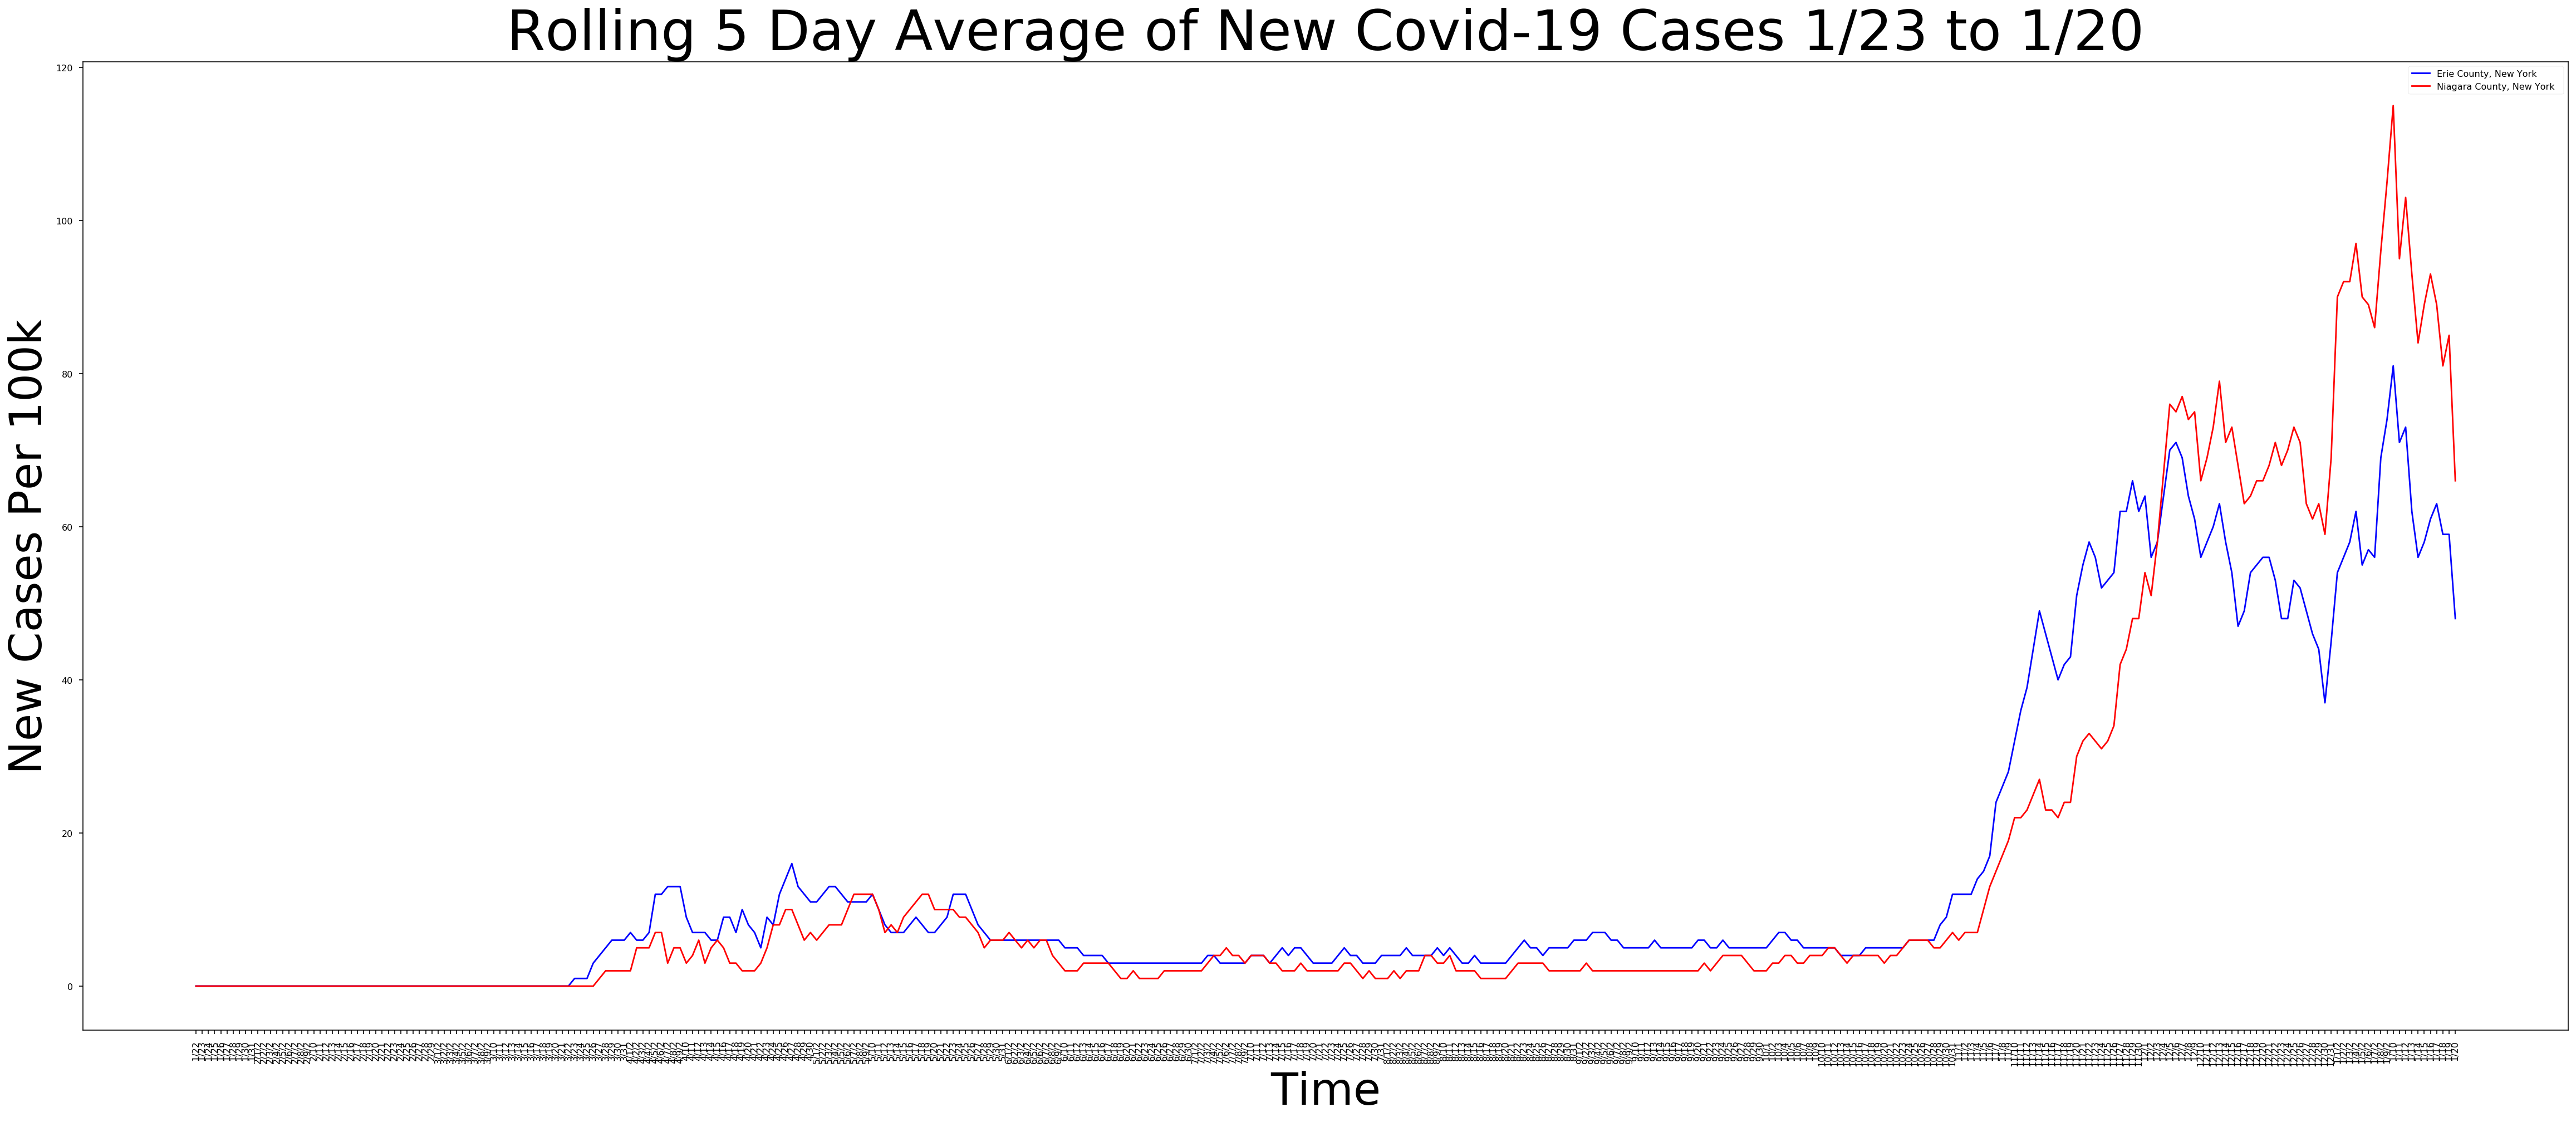

In [80]:
def  graph_rolling_average (df,df1_Name,  df2, df2_Name):
    date_series = df.index
    date_averages = df['Ave_per_100k'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    
    date_series2 = df2.index
    date_averages2 = df2['Ave_per_100k'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]
            date_values.append(date)
    
    
    fig = plt.figure(figsize=(8,6))
    plt.style.use('seaborn-paper')
    plt.figure(figsize=(40,16))
    plt.plot(date_values, date_averages, 'b', label=df1_Name)
    plt.plot(date_values, date_averages2, 'r', label = df2_Name)

    plt.ylabel('New Cases Per 100k',  fontsize=40)
    plt.xlabel('Time', fontsize=40)
    plt.xticks(rotation=90)
    x =len(date_values)-1
    y = str(date_values[x])
    
    title ='Rolling 5 Day Average of New Covid-19 Cases 1/23 to ' + y
    plt.title(title, fontsize=50)
    plt.legend()
    plt.show()
    return
df = one_shot('Erie', 'New York')
df2 = one_shot('Niagara' , 'New York')

#graph_rolling_average(df,'Erie County', df2, 'Los Angeles')
graph_rolling_average(df,'Erie County, New York', df2, 'Niagara County, New York  ')





<Figure size 576x432 with 0 Axes>

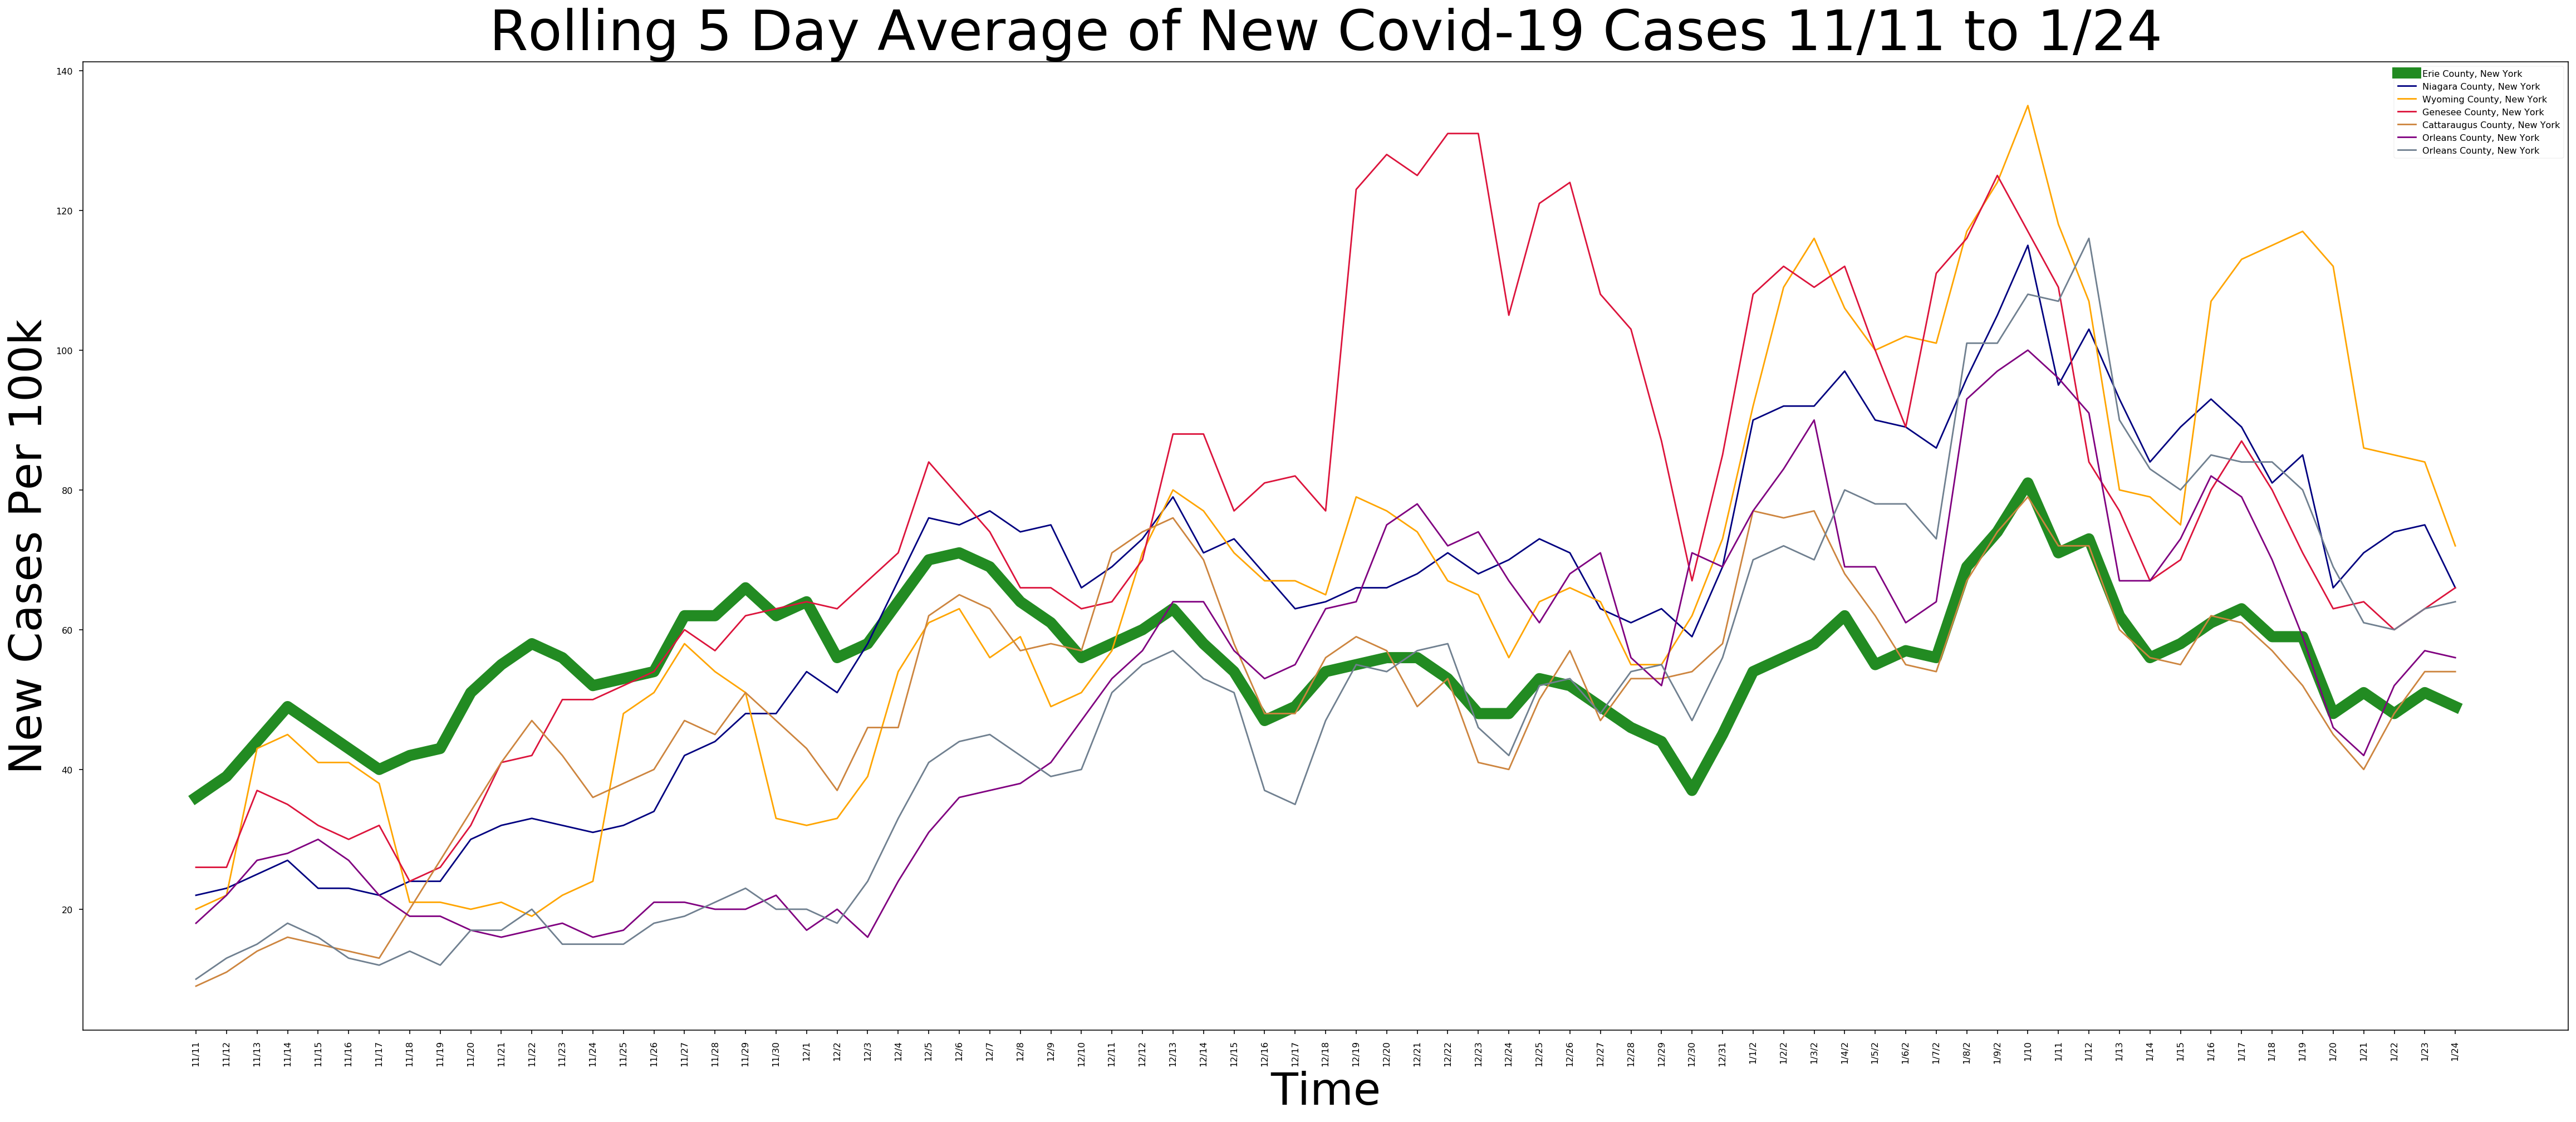

In [17]:
def  graph_rolling_average_7_counties (N, County1, State1, County2, State2, County3, State3, County4, State4, County5, State5, County6, State6, County7, State7 ):
    df = one_shot(County1, State1)
    n = df.shape[0] - N
    df = df.iloc[n:, :]
    date_series = df.index
    date_averages = df['Ave_per_100k'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    
    df2 = one_shot(County2, State2)
    n = df2.shape[0] - N
    df2 = df2.iloc[n:, :]
    date_series2 = df2.index
    date_averages2 = df2['Ave_per_100k'].values
    
    date_values2=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values2.append(date)
        else:
            date= dates[0:5]
            date_values2.append(date)
    
    df3= one_shot(County3, State3)
    n = df3.shape[0] - N
    df3 = df3.iloc[n:, :]
    date_series3 = df3.index
    date_averages3 = df3['Ave_per_100k'].values
    
    date_values3=[]
    for dates in date_series3:
        if(len(dates)==7):
            date = dates[0:4]
            date_values3.append(date)
        else:
            date= dates[0:5]

            date_values3.append(date)
    
    df4 =one_shot(County4, State4)
    n = df4.shape[0] - N
    df4 = df4.iloc[n:, :]
    date_series4 = df4.index
    date_averages4 = df4['Ave_per_100k'].values
    
    date_values4=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values4.append(date)
        else:
            date= dates[0:5]
            date_values4.append(date)
            
            
                
    df5 = one_shot(County5, State5)            
    n = df5.shape[0] - N
    df5 = df5.iloc[n:, :]
    date_series = df.index
    date_averages5 = df5['Ave_per_100k'].values
    
    date_values5=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values5.append(date)
        else:
            date= dates[0:5]

            date_values5.append(date)
    
    df6 = one_shot(County6, State6)
    n = df6.shape[0] - N
    df6 = df6.iloc[n:, :]
    date_series6 = df2.index
    date_averages6 = df6['Ave_per_100k'].values
    
    date_values6=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values6.append(date)
        else:
            date= dates[0:5]
            date_values6.append(date)
            
    df7 = one_shot(County7, State7)
    n = df7.shape[0] - N
    df7 = df7.iloc[n:, :]
    date_series7 = df2.index
    date_averages7 = df7['Ave_per_100k'].values
    
    date_values7=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values7.append(date)
        else:
            date= dates[0:5]
            date_values7.append(date)
    
    fig = plt.figure(figsize=(8,6))
    plt.style.use('seaborn-paper')
    plt.figure(figsize=(40,16))
    label1 = County1 + ' County, '+ State1
    label2 = County2 + ' County, '+ State2
    label3 = County3 + ' County, '+ State3
    label4 = County4 + ' County, '+ State4
    label5 = County5 + ' County, '+ State5
    label6 = County6 + ' County, '+ State6
    label7 = County6 + ' County, ' + State6
    plt.plot(date_values, date_averages, 'forestgreen', label=label1, linewidth = 10)
    plt.plot(date_values2, date_averages2, 'navy', label = label2)
    plt.plot(date_values, date_averages3, 'orange', label=label3)
    plt.plot(date_values, date_averages4, 'crimson', label = label4)
    plt.plot(date_values, date_averages5, 'peru', label=label5)
    plt.plot(date_values, date_averages6, 'purple', label = label6)
    plt.plot(date_values, date_averages7, 'slategray', label = label7)



    
    
    
    
    plt.ylabel('New Cases Per 100k',  fontsize=40)
    plt.xlabel('Time', fontsize=40)
    plt.xticks(rotation=90)
    x =len(date_values)-1
    y = str(date_values[x])
    z = str(date_values[0])
    title ='Rolling 5 Day Average of New Covid-19 Cases ' + z + ' to ' + y
    plt.title(title, fontsize=50)
    plt.legend()
    plt.show()
    return
df = one_shot('Erie', 'New York')
df2 = one_shot('Niagara' , 'New York')

#graph_rolling_average(df,'Erie County', df2, 'Los Angeles')
graph_rolling_average_7_counties(75, 'Erie' , 'New York',  'Niagara' , 'New York', 'Wyoming' , 'New York',  'Genesee' , 'New York', 'Cattaraugus', 'New York', 'Orleans','New York', 'Chautauqua','New York' )

In [25]:
 confirmed.iloc[:2, :10]

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   

         Lat      Long_  
0  32.539527 -86.644082  
1  30.727750 -87.722071

In [18]:
d_d = deaths.iloc[:2, 12:]
d_dates = d_d.columns
d_dates
d_tran = deaths.T
us_tran = d_tran.iloc[12:, :]
us_tran.head()
col = us_tran.columns
daily_totals = []
col = us_tran.columns
daily_totals = []
in_vals = us_tran.values
x=[]
for i in in_vals:
    x.append(sum(i))



In [19]:
col = us_tran.columns
daily_totals = []
in_vals = us_tran.values
x=[]
for i in in_vals:
    x.append(sum(i))
x
j=0
new_cases=[]
for case in x:
    if(j==0):
        new_cases.append(case)
        j=j+1
        y=0
    else:


        current = sum(new_cases)
        nc= case - current
        if(case > current):

                new_cases.append(nc)
        else:
            new_cases.append(0)

        y=y+1
us_total_new_daily_deaths = new_cases


fig = plt.figure(figsize=(8,6))
plt.style.use('seaborn-paper')
plt.figure(figsize=(40,16))
plt.plot(d_dates, us_total_new_daily_deaths, 'b', label='US Daily Deaths')
plt.title('US Daily Deaths' ,fontsize=50)
plt.ylabel('New Deaths',  fontsize=40)
plt.xlabel('Time', fontsize=40)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

In [20]:
length = len(us_total_new_daily_deaths)
weekly_deaths_us_total = []
for i in range(0,len(us_total_new_daily_deaths)):
    if(i<7):
        dan=1
    else:
        average = (us_total_new_daily_deaths[i]+us_total_new_daily_deaths[i-1]+us_total_new_daily_deaths[i-2]+us_total_new_daily_deaths[i-3]+us_total_new_daily_deaths[i-4] +us_total_new_daily_deaths[i-5]+us_total_new_daily_deaths[i-6])/7
        weekly_deaths_us_total.append(average)
fig = plt.figure(figsize=(8,6))
plt.style.use('seaborn-paper')

plt.figure(figsize=(40,16))
plt.plot(d_dates[7:], weekly_deaths_us_total, 'b', label='US 7-Day Average Deaths')
plt.title('US 7-Day Average Deaths' ,fontsize=50)
plt.ylabel('New Deaths',  fontsize=40)
plt.xlabel('Time', fontsize=40)

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Time')

<Figure size 576x432 with 0 Axes>

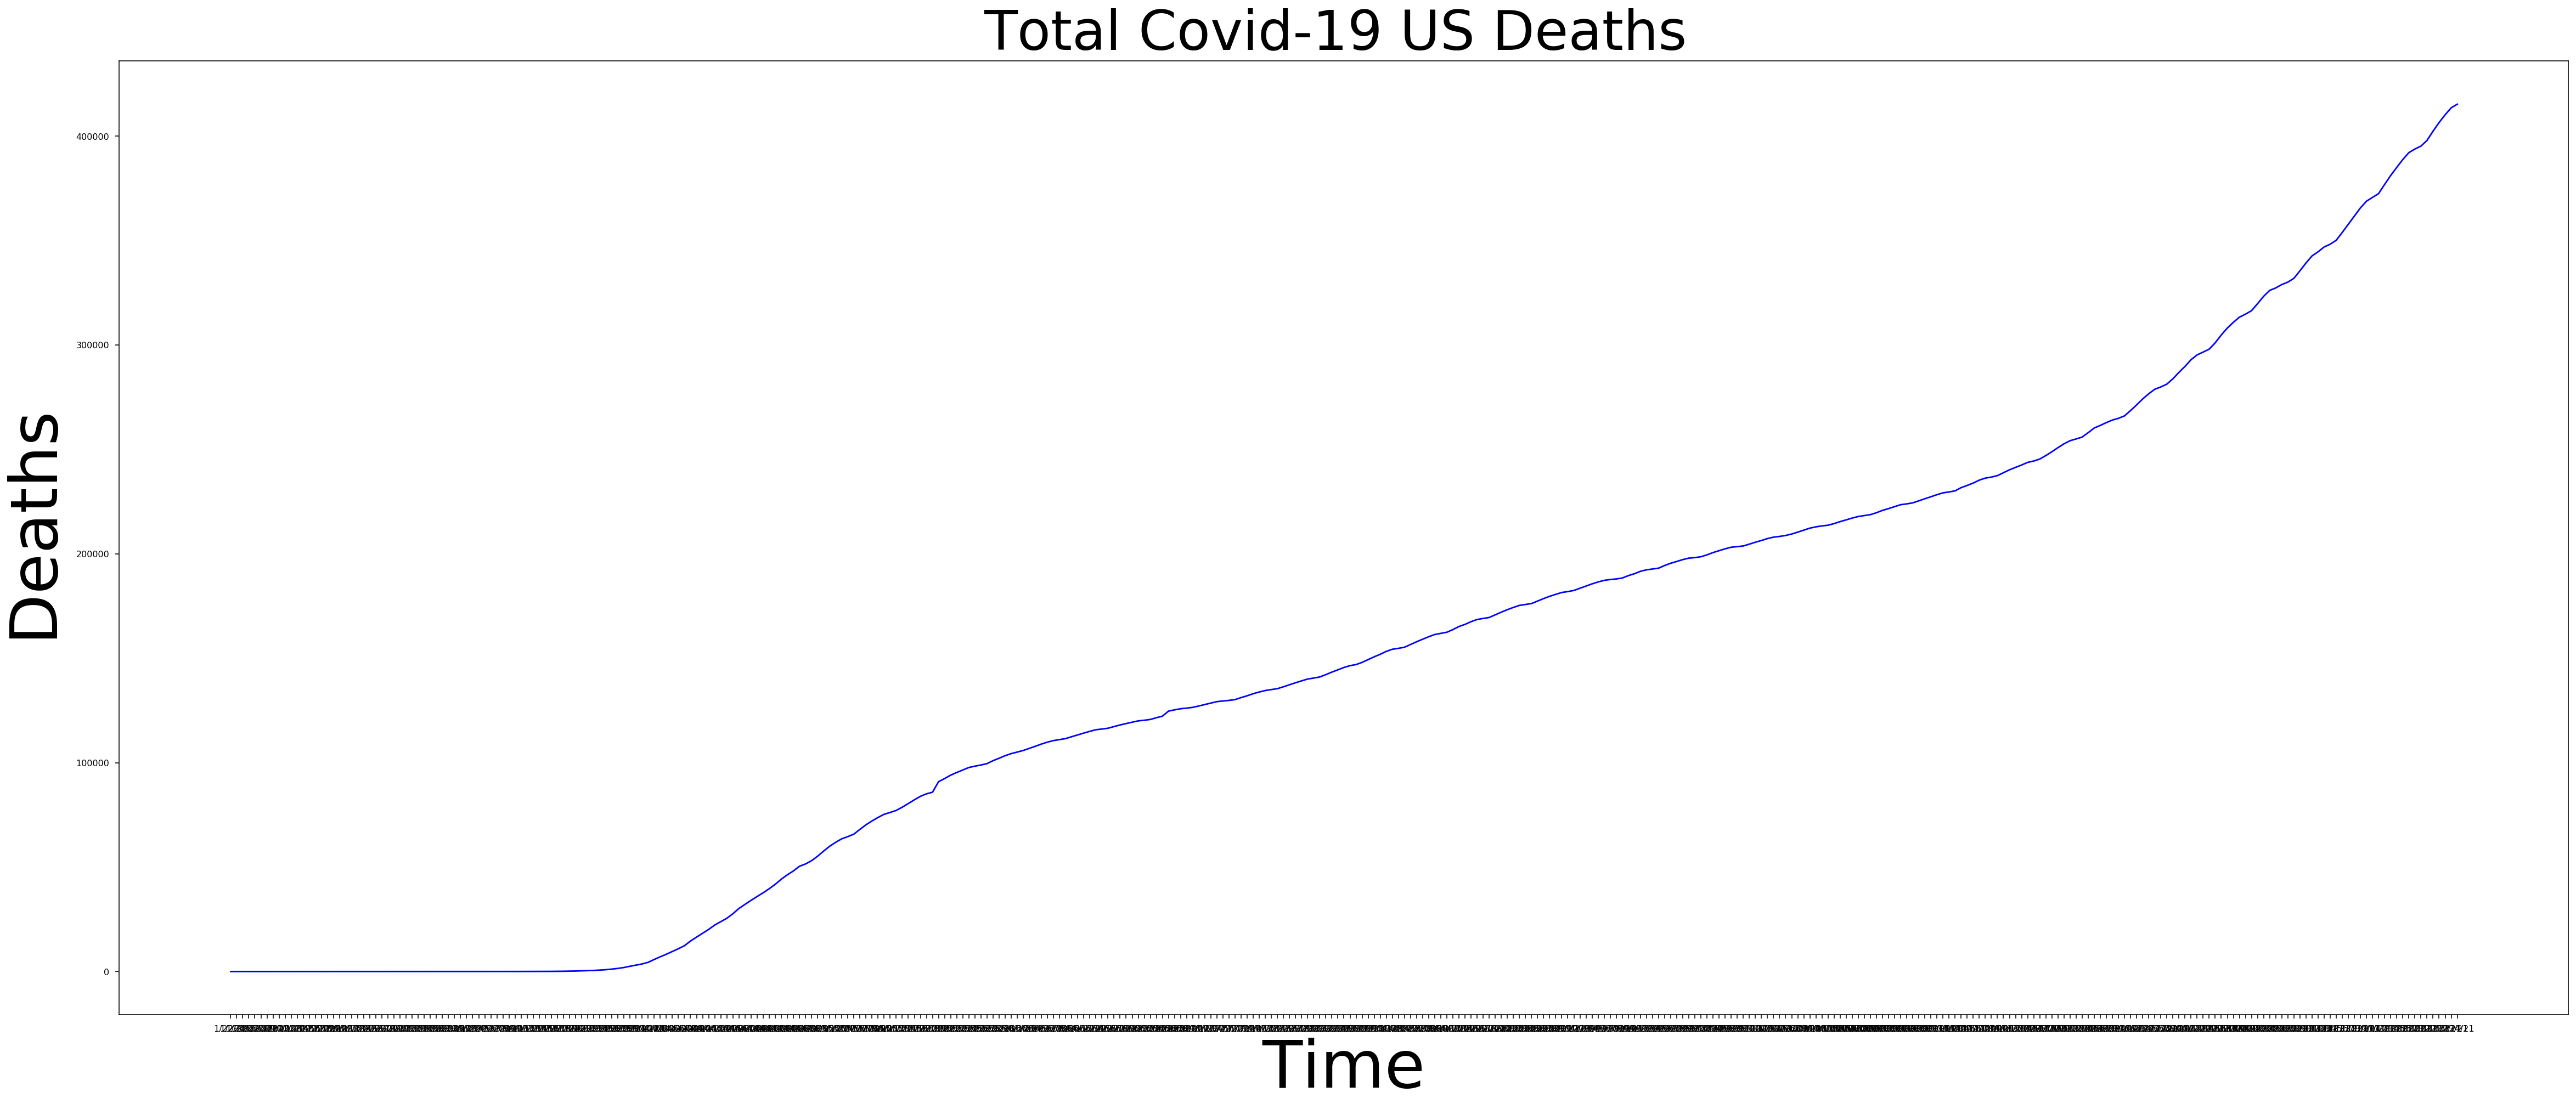

In [21]:
fig = plt.figure(figsize=(8,6))
plt.style.use('seaborn-paper')
plt.figure(figsize=(40,16))
plt.plot(d_dates, x, 'b', label='US Dates')
plt.title('Total Covid-19 US Deaths ' ,fontsize=50)
plt.ylabel(' Deaths',  fontsize=60)
plt.xlabel('Time', fontsize=60)

In [105]:
state_list = make_state_list()
len(state_list)
state_populations = []
state_deaths = []
state_d_per_100k = []
for state in state_list:
    df = deaths.loc[deaths['Province_State']== state]
    state_pop = sum(df['Population'].values)
    state_populations.append(state_pop)
    state100k = state_pop /100000
    
    n = df.shape[1] -1
    t_deaths = int(sum(df.iloc[:, n:].values))
    state_deaths.append(t_deaths)
    state_deaths_per_100k = t_deaths / state100k
    state_d_per_100k.append(int(state_deaths_per_100k))
df = pd.DataFrame()
df['State'] = state_list
df['Total_Population']= state_populations 
df['Deaths'] = state_deaths
df['Deaths_Per_100k'] = state_d_per_100k
df
df.to_excel('Deaths_per_State.xlsx')

In [98]:
deaths.head(1)

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   

         Lat      Long_  ... 1/11/21  1/12/21  1/13/21  1/14/21  1/15/21  \
0  32.539527 -86.644082  ...      55       55       55       55       55   

   1/16/21  1/17/21  1/18/21  1/19/21  1/20/21  
0       55       55       55       55       55  

[1 rows x 377 columns]

In [30]:
tp = sum(deaths.Population.values)
tp

332865687

In [34]:
ny = deaths.loc[deaths['Province_State']=='New York']
p= ny.loc[deaths['Admin2']=='Erie']
pp = p.Population.values / tp
dp = p['1/15/21'].values / d
pp , dp

(array([0.00275998]), array([0.00344807]))

<Figure size 576x432 with 0 Axes>

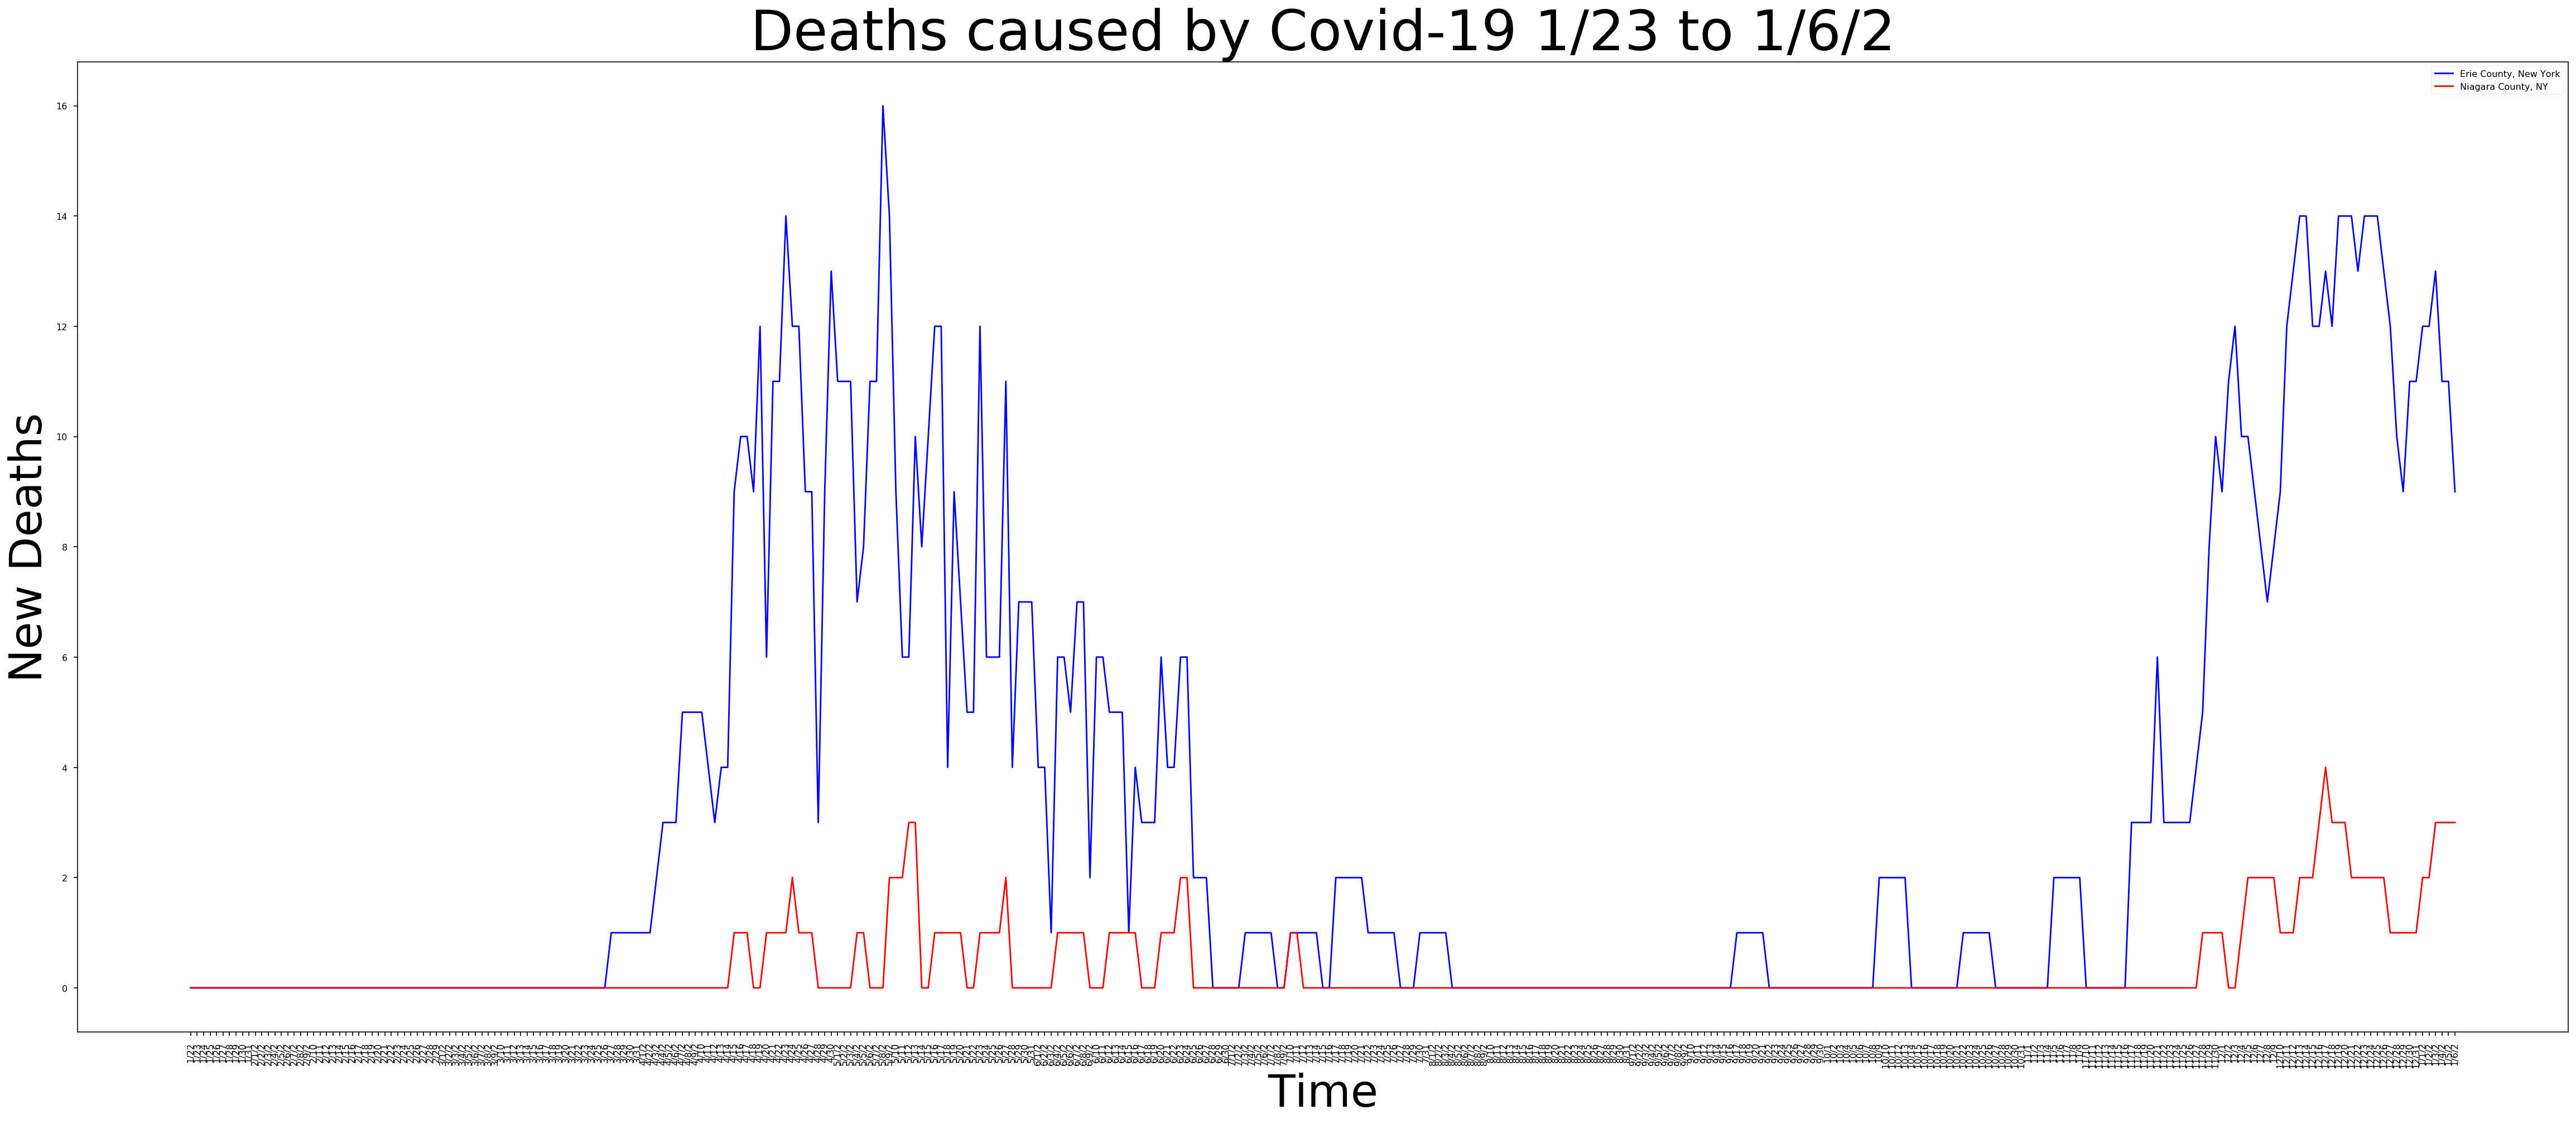

In [19]:
def  graph_average_deaths (df,df1_Name,  df2, df2_Name):
    date_series = df.index
    date_averages = df['Average_Deaths'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    
    date_series2 = df2.index
    date_averages2 = df2['Average_Deaths'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]
            date_values.append(date)
    
    
    fig = plt.figure(figsize=(8,6))
    plt.style.use('seaborn-paper')
    plt.figure(figsize=(40,16))
    plt.plot(date_values, date_averages, 'b', label=df1_Name)
    plt.plot(date_values, date_averages2, 'r', label = df2_Name)

    plt.ylabel('New Deaths',  fontsize=40)
    plt.xlabel('Time', fontsize=40)
    plt.xticks(rotation=90)
    x =len(date_values)-1
    y = str(date_values[x])
    
    title ='Deaths caused by Covid-19 1/23 to ' + y
    plt.title(title, fontsize=50)
    plt.legend()
    plt.show()
    return
df = one_shot('Erie', 'New York')
df2 = one_shot('Niagara' , 'New York')

#graph_rolling_average(df,'Erie County', df2, 'Los Angeles')
graph_average_deaths(df,'Erie County, New York', df2, 'Niagara County, NY  ')






Confirmed Cases in Erie County, New York 60 days prior to 1/24


<Figure size 576x432 with 0 Axes>

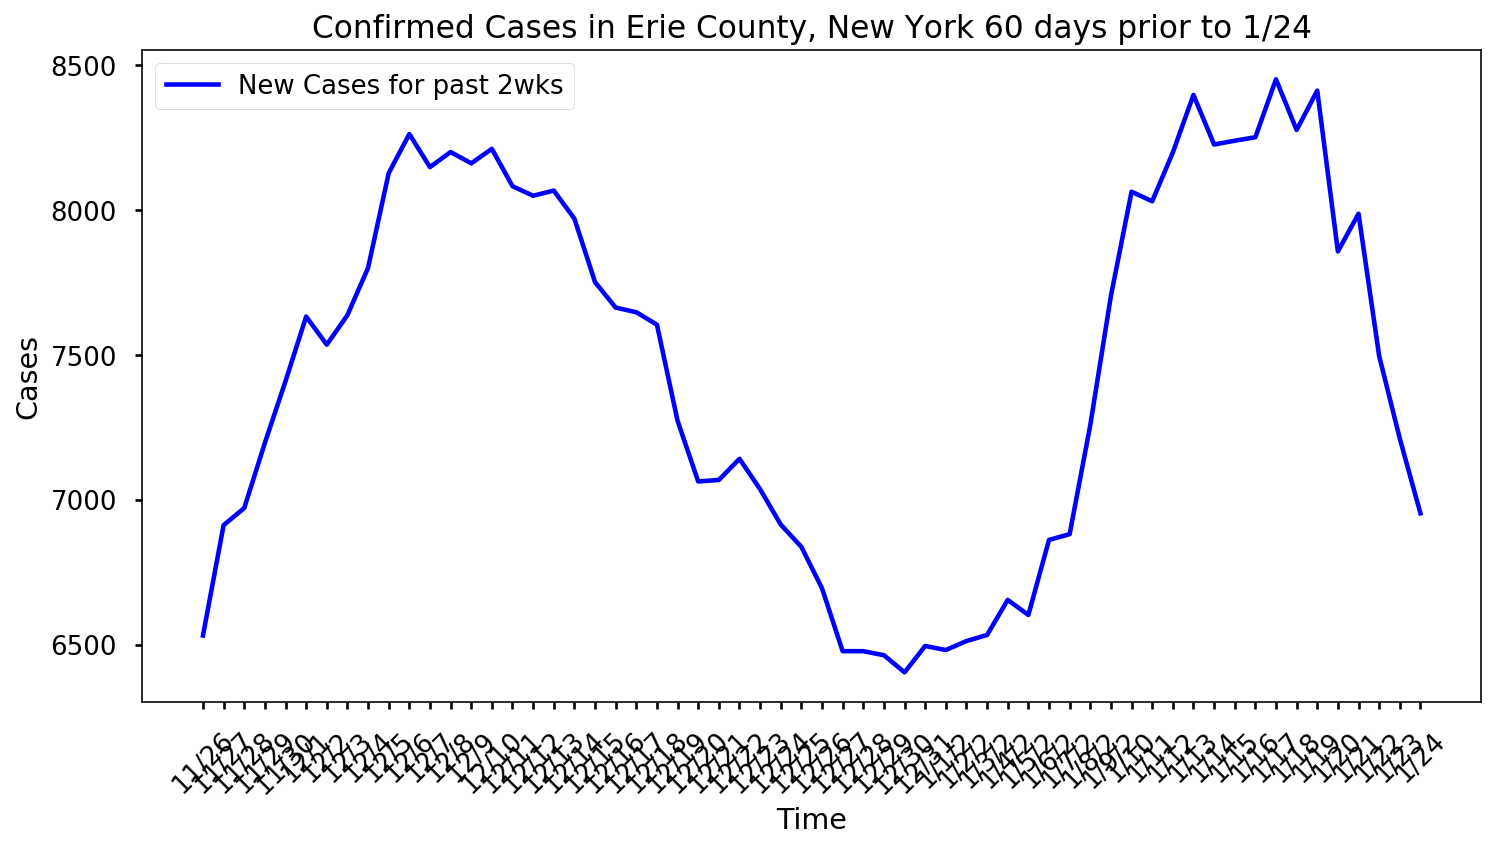

In [22]:

def graph_n_days_ago(County, State , n):
    df = one_shot(County, State)
    N= df.shape[0] - n
    df= df.iloc[N:, :]
    
    
    date_series = df.index
    date_averages = df['New_Cases_2wks'].values

    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    #print(date_values)
    x =len(date_values)-1
    plt.style.use('seaborn-talk')
    fig = plt.figure(figsize=(8,6))
    y = str(date_values[x])
    n = str(n)
    title = "Confirmed Cases in " +County + " County, " + State +" "+ n +" days prior to " + y
    print(title)

    plt.figure(figsize=(12,6))
    plt.plot(date_values, date_averages, 'b', label='New Cases for past 2wks')

    plt.ylabel('Cases')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()
    return
#graph_n_days_ago('Niagara','New York' , 20), 
graph_n_days_ago('Erie','New York' , 60)


Confirmed Cases in King County, Washington 30 days prior to 1/24


<Figure size 576x432 with 0 Axes>

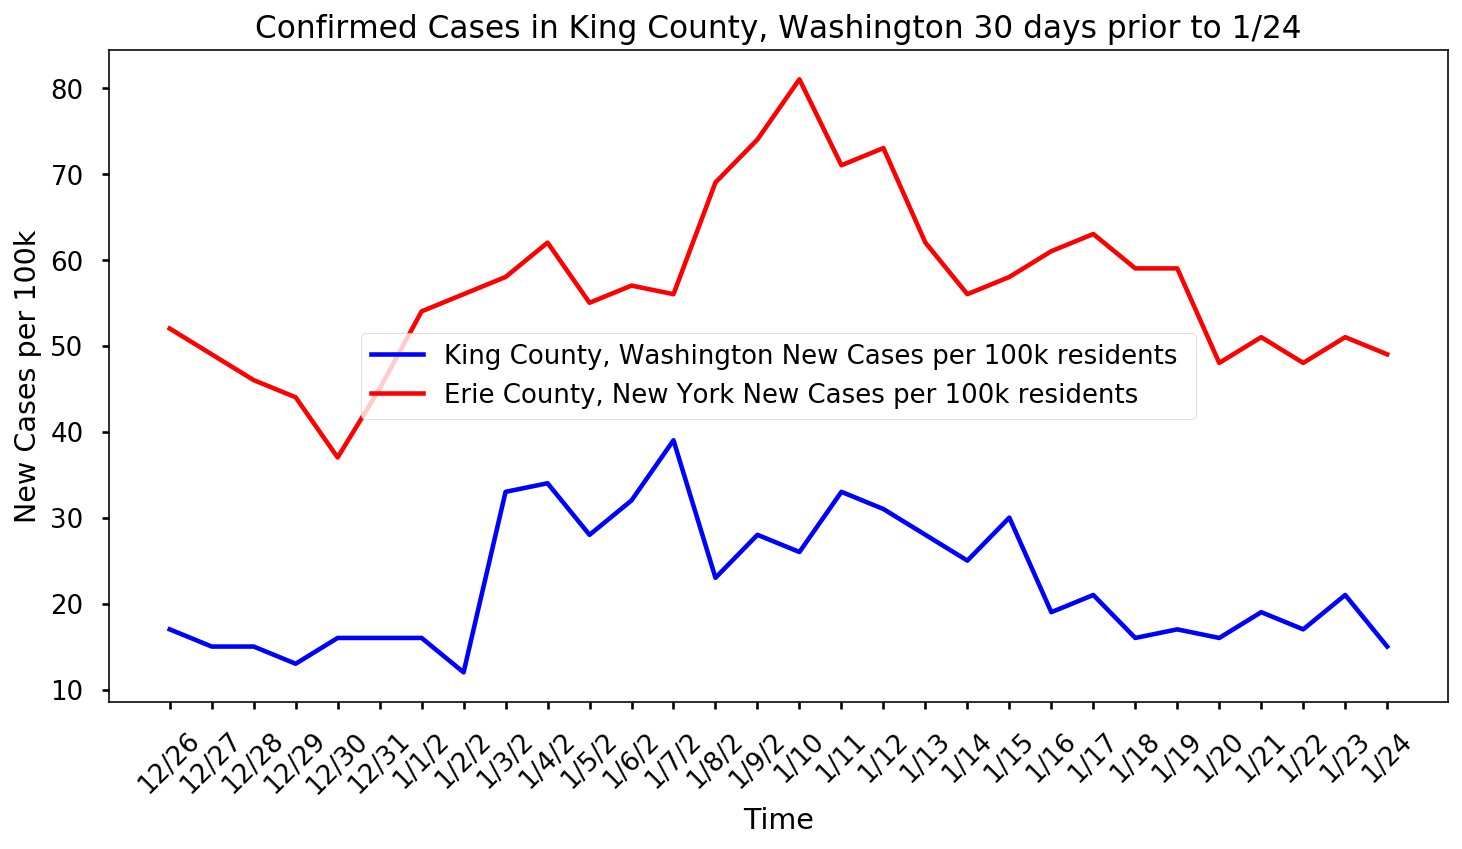

In [23]:

def graph_2_counties_n_days_ago(County, State , County2, State2, n):
    df = one_shot(County, State)
    N= df.shape[0] - n
    df= df.iloc[N:, :]
    
    
    date_series = df.index
    date_averages = df['Ave_per_100k'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    
    df2 = one_shot(County2, State2)
    N= df2.shape[0] - n
    df2= df2.iloc[N:, :]
    
    
    date_series2 = df2.index
    date_averages2 = df2['Ave_per_100k'].values
    
    
    date_values2=[]
    for dates in date_series2:
        if(len(dates)==7):
            date = dates[0:4]
            date_values2.append(date)
        else:
            date= dates[0:5]

            date_values2.append(date)
    #print(date_values)
    x =len(date_values)-1
    plt.style.use('seaborn-talk')
    fig = plt.figure(figsize=(8,6))
    y = str(date_values[x])
    n = str(n)
    title = "Confirmed Cases in " +County + " County, " + State +" "+ n +" days prior to " + y
    print(title)

    plt.figure(figsize=(12,6))
    label1 = County + ' County, ' + State + ' New Cases per 100k residents '
    label2 = County2 + ' County, ' + State2 + ' New Cases per 100k residents '
    plt.plot(date_values, date_averages, 'b', label=label1)
    plt.plot(date_values2, date_averages2, 'r', label=label2)

    plt.ylabel('New Cases per 100k')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()
    return
graph_2_counties_n_days_ago('King' , 'Washington' ,'Erie','New York' , 30)




Confirmed Cases in Cattaraugus County, New York 40 days prior to 1/6/2


<Figure size 576x432 with 0 Axes>

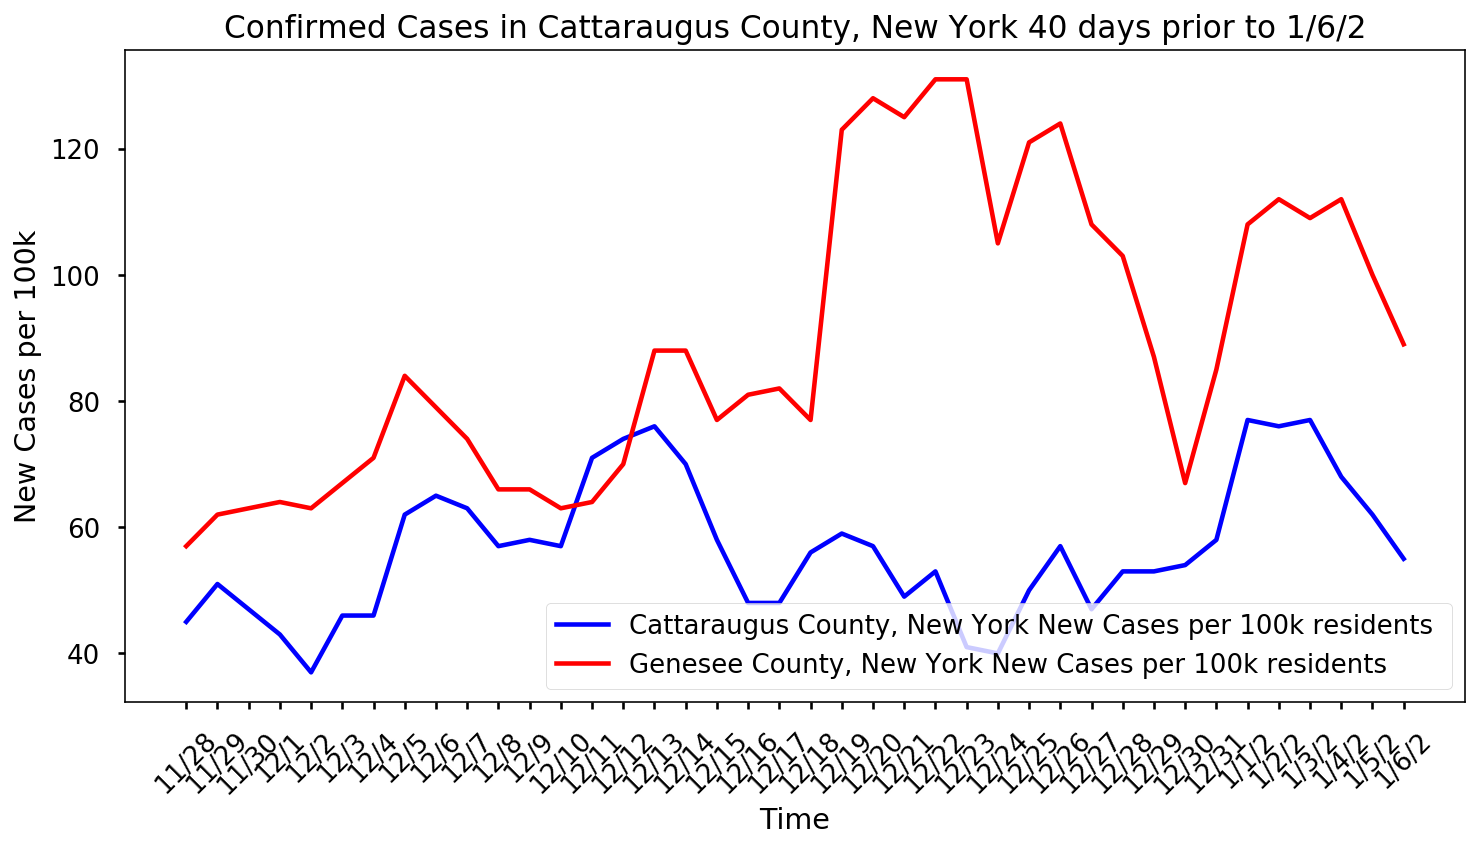

In [26]:
graph_2_counties_n_days_ago('Cattaraugus','New York' ,'Genesee','New York' , 40)

Confirmed Cases in Wyoming County, New York 40 days prior to 1/6/2


<Figure size 576x432 with 0 Axes>

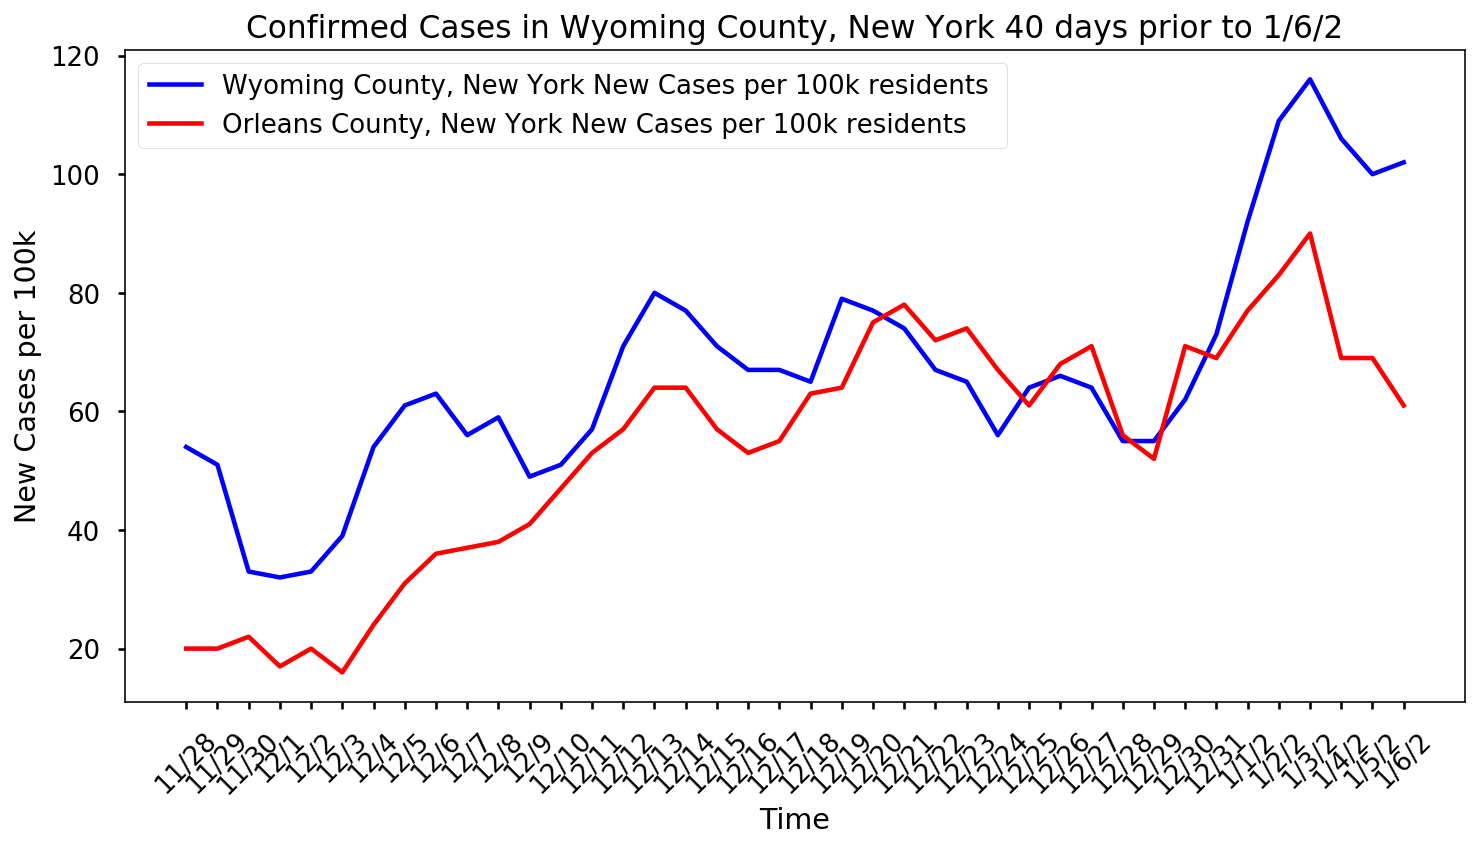

In [27]:
graph_2_counties_n_days_ago('Wyoming','New York' ,'Orleans','New York' , 40)

Confirmed Cases in Chautauqua County, New York 40 days prior to 1/6/2


<Figure size 576x432 with 0 Axes>

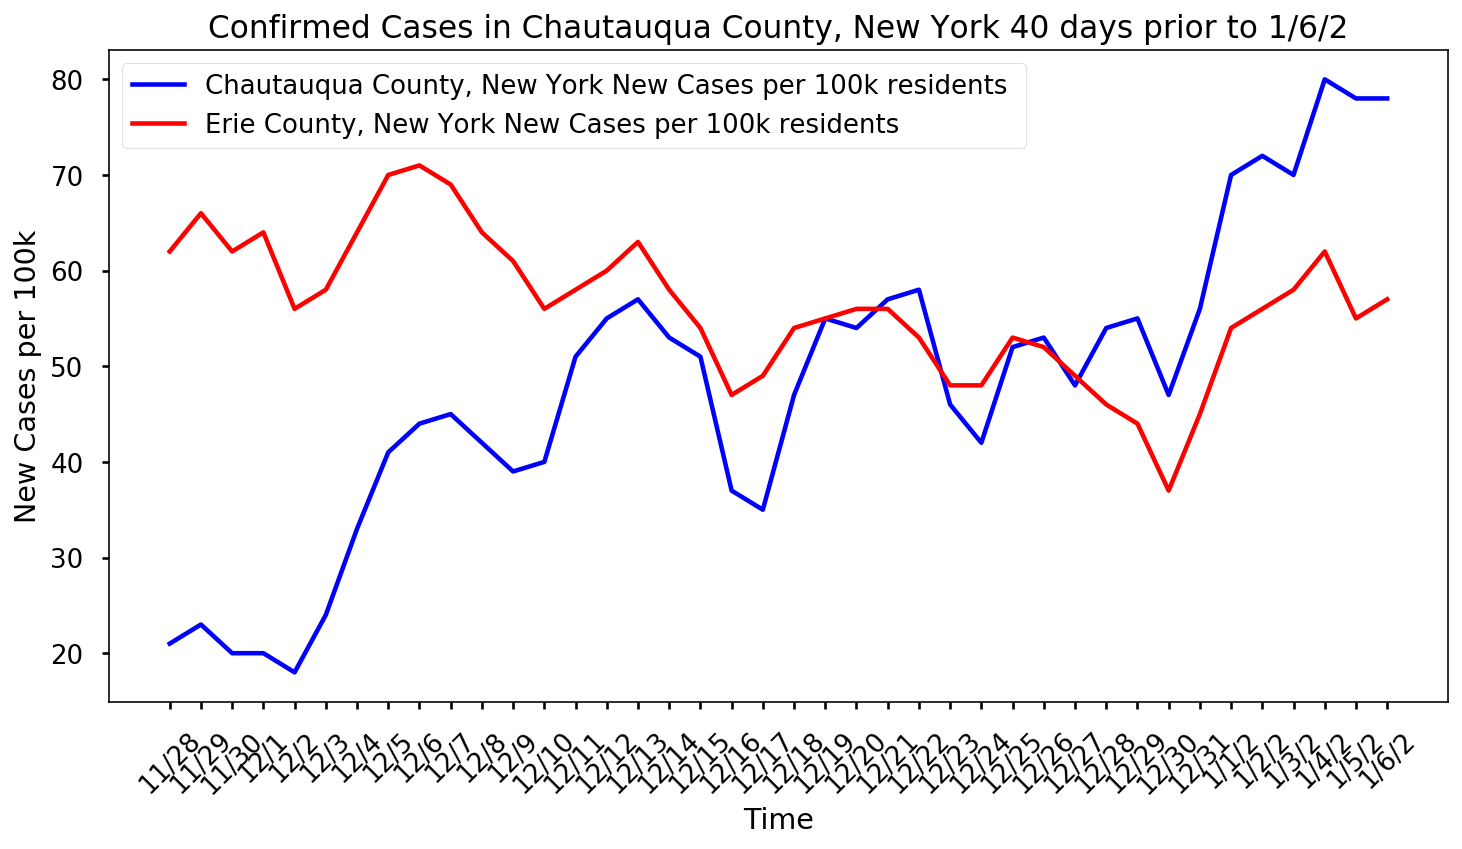

In [28]:
graph_2_counties_n_days_ago('Chautauqua','New York' ,'Erie','New York' , 40)

Sarasota County, Florida 55 days prior to 12/30


<Figure size 576x432 with 0 Axes>

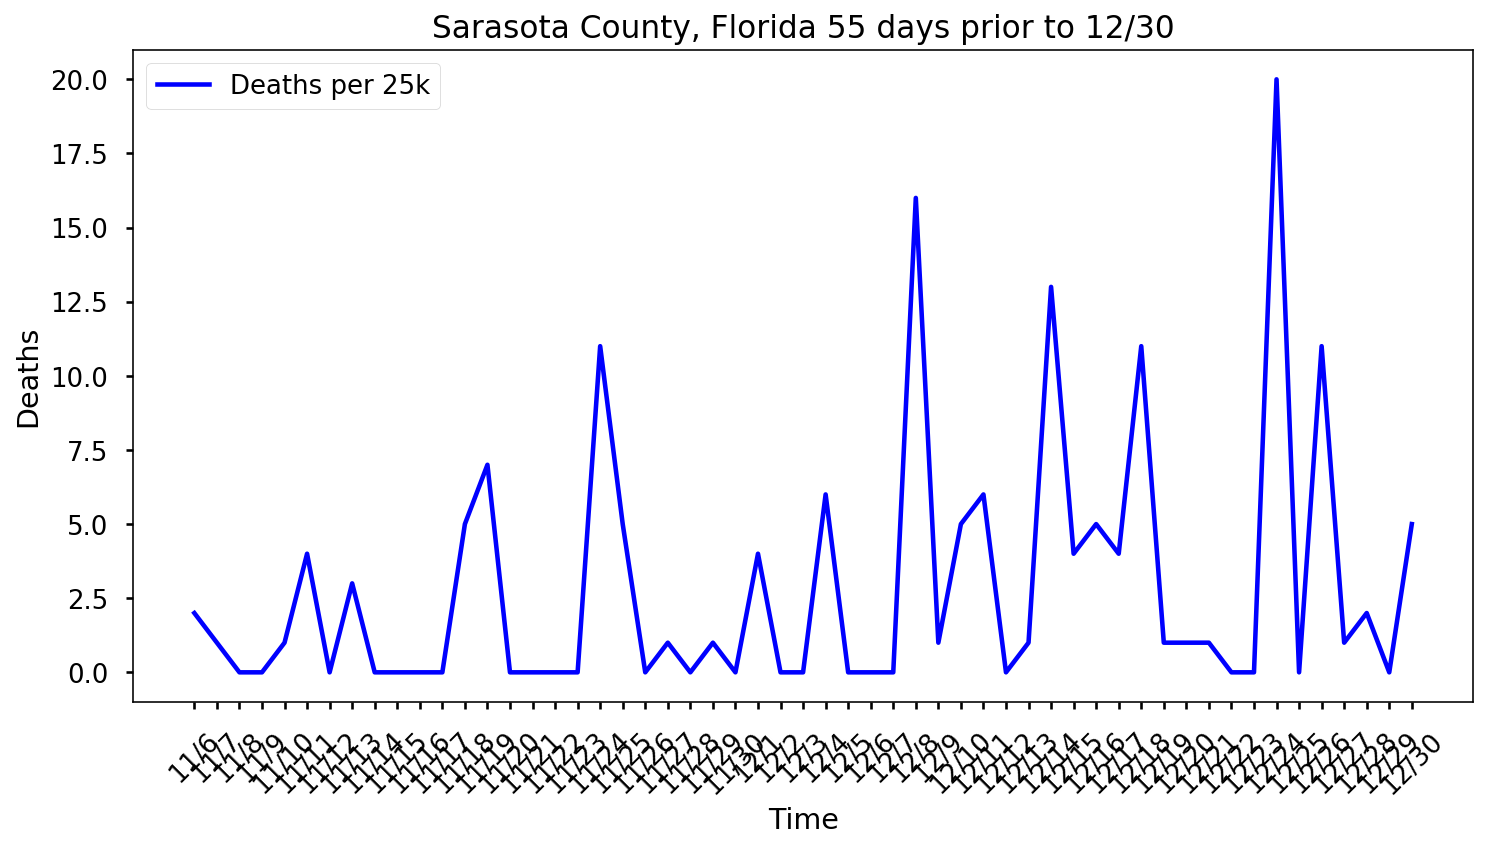

In [21]:

def graph_deaths_n_days_ago(County, State , n):
    df = one_shot(County, State)
    N= df.shape[0] - n
    df= df.iloc[N:, :]
    
    
    date_series = df.index
    date_averages = df['New_Deaths'].values

    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    #print(date_values)
    x =len(date_values)-1
    plt.style.use('seaborn-talk')
    fig = plt.figure(figsize=(8,6))
    y = str(date_values[x])
    n = str(n)
    title = County + " County, " + State +" "+ n +" days prior to " + y
    print(title)

    plt.figure(figsize=(12,6))
    plt.plot(date_values, date_averages, 'b', label='Deaths per 25k')

    plt.ylabel('Deaths')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()
    return
graph_deaths_n_days_ago('Sarasota','Florida' , 55)

Erie County vs Gaston County  32 days prior to 12/19


<Figure size 576x432 with 0 Axes>

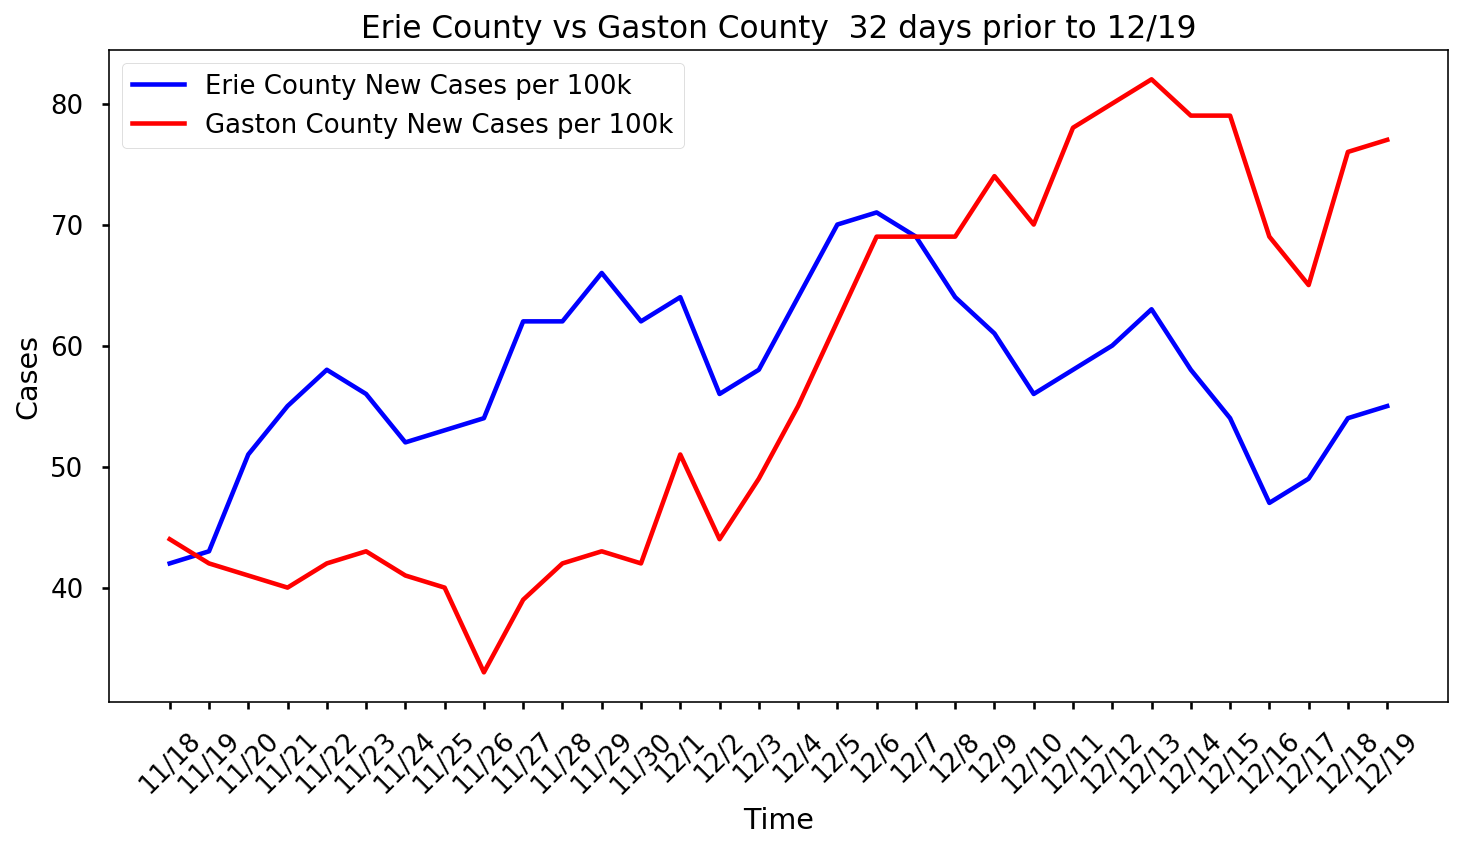

In [28]:
def Compare_Counties_n_days_ago(County, State , County2, State2, n):
    df = one_shot(County, State)
    df2 = one_shot(County2, State2)
    N= df.shape[0] - n
    N= df2.shape[0] - n
    
    df= df.iloc[N:, :]   
    date_series = df.index
    date_averages = df['Ave_per_100k'].values

    
   
    df2= df2.iloc[N:, :]   
    date_series2 = df2.index
    date_averages2 = df2['Ave_per_100k'].values
    
    date_values=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values.append(date)
        else:
            date= dates[0:5]

            date_values.append(date)
    date_values2=[]
    for dates in date_series:
        if(len(dates)==7):
            date = dates[0:4]
            date_values2.append(date)
        else:
            date= dates[0:5]

            date_values2.append(date)
    #print(date_values)
    x =len(date_values)-1
    plt.style.use('seaborn-talk')
    fig = plt.figure(figsize=(8,6))
    y = str(date_values[x])
    n = str(n)
    title = County + " County vs " +County2 +" County  "+ n +" days prior to " + y
    print(title)
    label1 = County + " County New Cases per 100k"
    label2 = County2 + " County New Cases per 100k"
    plt.figure(figsize=(12,6))
    plt.plot(date_values, date_averages, 'b', label=label1)
    plt.plot(date_values2, date_averages2, 'r', label=label2)

    plt.ylabel('Cases')
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.title(title)
    plt.legend()
    plt.show()
    return
Compare_Counties_n_days_ago("Erie", "New York" , "Gaston", "North Carolina", 32)

Erie County vs Gaston County  120 days prior to 12/19


<Figure size 576x432 with 0 Axes>

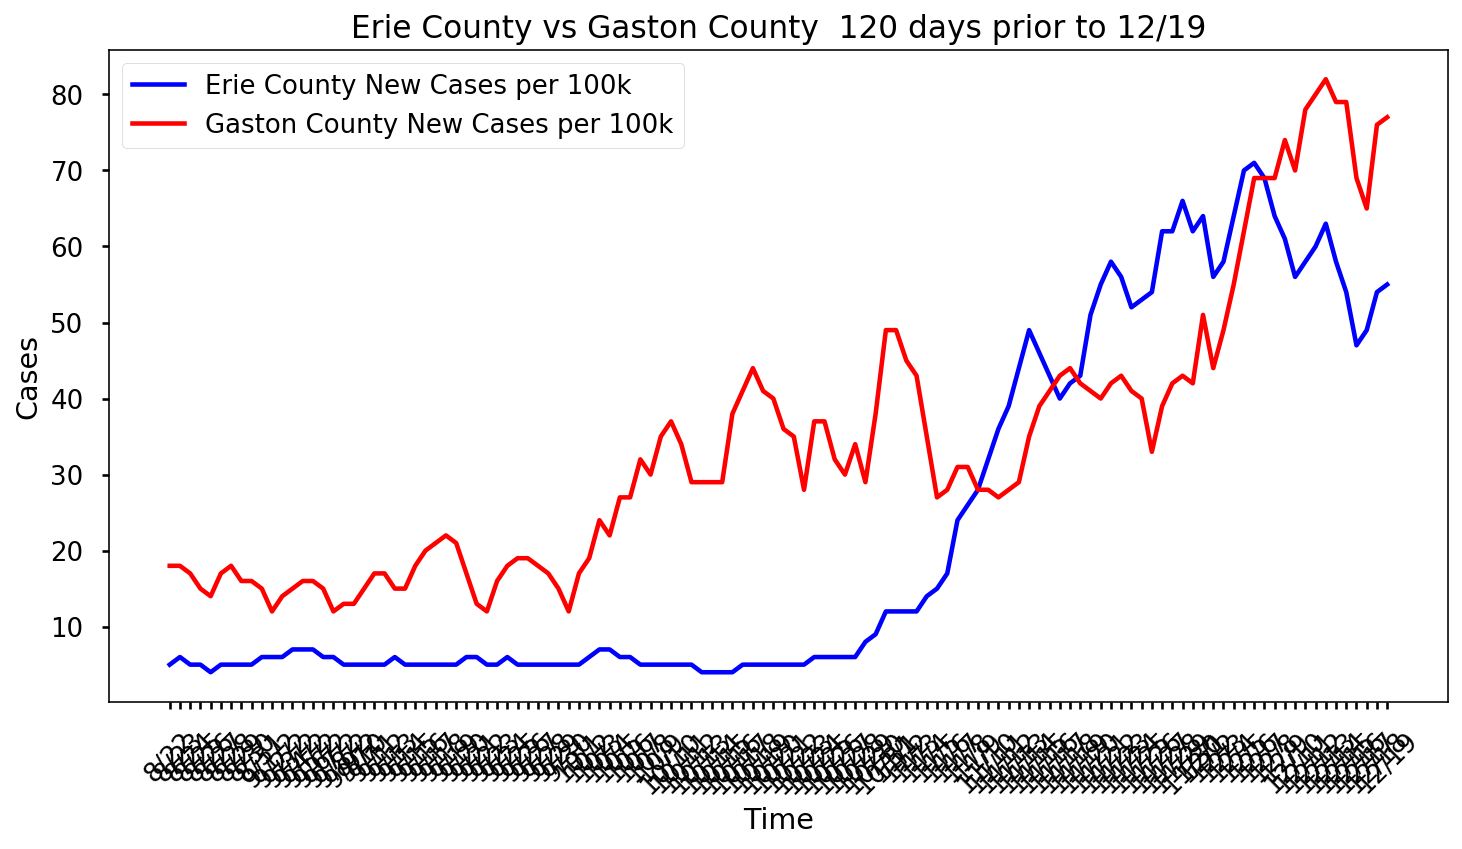

In [29]:
Compare_Counties_n_days_ago("Erie", "New York" , "Gaston", "North Carolina", 120)

Erie County vs Orange County  14 days prior to 12/19


<Figure size 576x432 with 0 Axes>

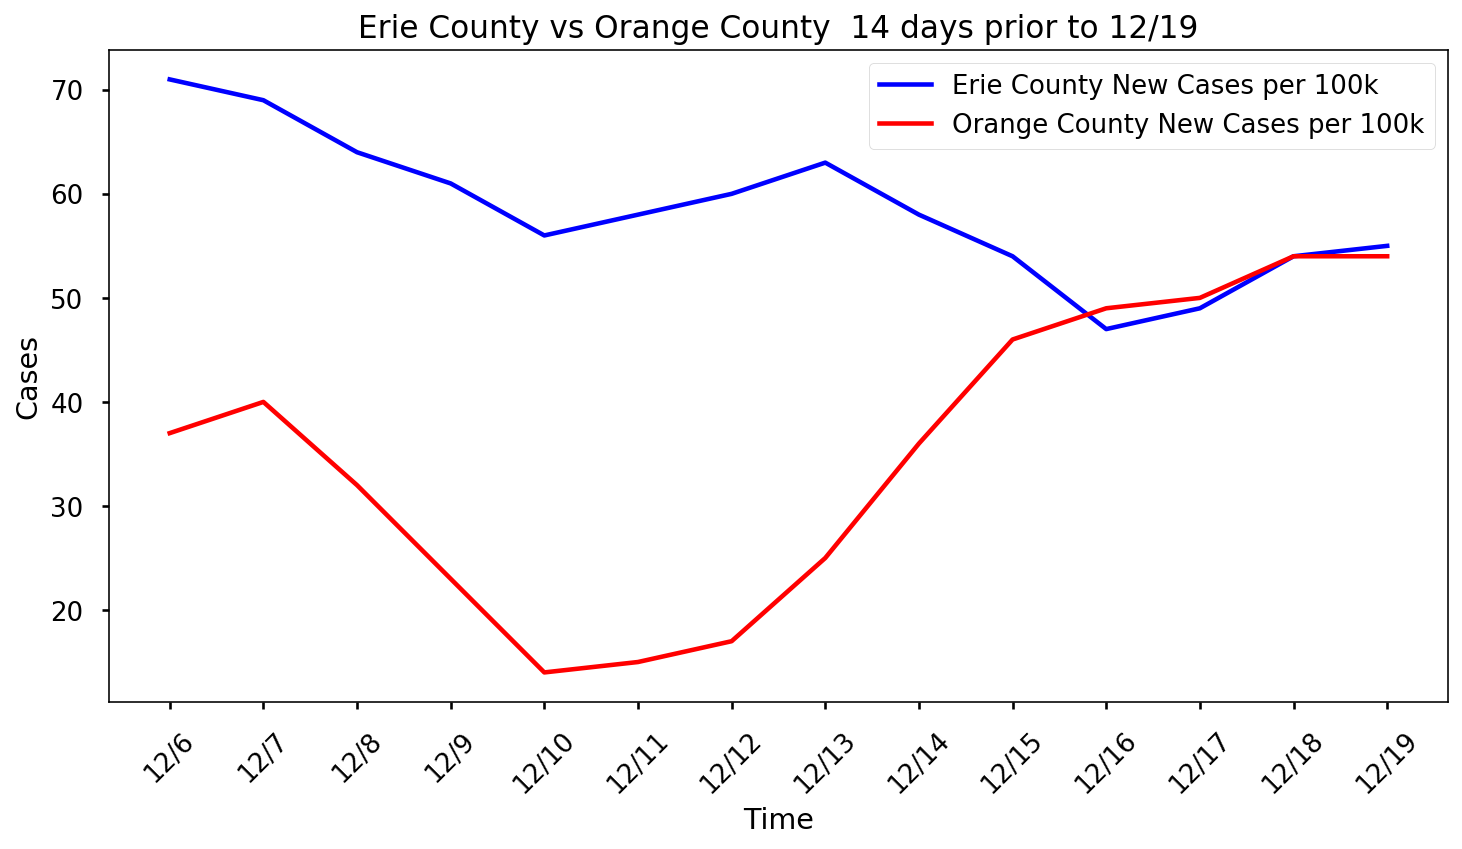

In [19]:
Compare_Counties_n_days_ago("Erie", "New York" , "Orange", "Florida", 14)

In [31]:
nyd = make_state_df(deaths, 'New York')
p = nyd.Population
county_names = []
for i in p:
    if(i>0):
        county_names.append(i)
        
    else:
        y =0
len(county_names)

62

In [52]:
erie.tail(10)

Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
Date                                                                      
12/4/20       27903     859        793           6              0.03037   
12/5/20       28681     870        778          11              0.03122   
12/6/20       29337     872        656           2              0.03193   
12/7/20       29720     883        383          11              0.03235   
12/8/20       30073     891        353           8              0.03273   
12/9/20       30719     903        646          12              0.03344   
12/10/20      31282     919        563          16              0.03405   
12/11/20      32015     935        733          16              0.03485   
12/12/20      32489     948        474          13              0.03536   
12/13/20      33009     965        520          17              0.03593   

          Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k County  \
Date                                                                       
12/4/20       592            64            7800               849   Erie   
12/5/20       650            70            8127               884   Erie   
12/6/20       659            71            8262               899   Erie   
12/7/20       640            69            8148               886   Erie   
12/8/20       592            64            8200               892   Erie   
12/9/20       563            61            8161               888   Erie   
12/10/20      520            56            8211               893   Erie   
12/11/20      535            58            8082               879   Erie   
12/12/20      553            60            8049               876   Erie   
12/13/20      587            63            8067               878   Erie   

             State  
Date                
12/4/20   New York  
12/5/20   New York  
12/6/20   New York  
12/7/20   New York  
12/8/20   New York  
12/9/20   New York  
12/10/20  New York  
12/11/20  New York  
12/12/20  New York  
12/13/20  New York

In [53]:
fl = make_state_df(confirmed, 'Florida')
flor = fl.loc[fl['County']=='Orange']
orange = one_shot('Orange', 'Florida')
orange.tail(20)

Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
Date                                                                      
11/24/20      55526     635        479           6              0.03985   
11/25/20      55966     635        440           0              0.04016   
11/26/20      55966     635          0           0              0.04016   
11/27/20      57101     642       1135           7              0.04098   
11/28/20      57321     645        220           3              0.04114   
11/29/20      57805     645        484           0              0.04148   
11/30/20      58325     645        520           0              0.04186   
12/1/20       58862     646        537           1              0.04224   
12/2/20       59218     648        356           2              0.04250   
12/3/20       59791     652        573           4              0.04291   
12/4/20       60392     651        601           0              0.04334   
12/5/20       61030     656        638           4              0.04380   
12/6/20       61474     657        444           1              0.04412   
12/7/20       62041     658        567           1              0.04452   
12/8/20       60291     642          0           0              0.04327   
12/9/20       61055     652          0           0              0.04382   
12/10/20      61697     677          0          19              0.04428   
12/11/20      62522     678        481           1              0.04487   
12/12/20      63281     679        759           1              0.04541   
12/13/20      63814     679        533           0              0.04580   

          Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k  County  \
Date                                                                        
11/24/20      428            30            6104               438  Orange   
11/25/20      405            29            6214               445  Orange   
11/26/20      325            23            5831               418  Orange   
11/27/20      493            35            6655               477  Orange   
11/28/20      454            32            6491               465  Orange   
11/29/20      455            32            6230               447  Orange   
11/30/20      471            33            6437               461  Orange   
12/1/20       579            41            6564               471  Orange   
12/2/20       423            30            6356               456  Orange   
12/3/20       494            35            6407               459  Orange   
12/4/20       517            37            6451               462  Orange   
12/5/20       541            38            6689               480  Orange   
12/6/20       522            37            6838               490  Orange   
12/7/20       564            40            6994               501  Orange   
12/8/20       450            32            6515               467  Orange   
12/9/20       329            23            6075               435  Orange   
12/10/20      202            14            6075               435  Orange   
12/11/20      209            15            5421               389  Orange   
12/12/20      248            17            5960               427  Orange   
12/13/20      354            25            6009               431  Orange   

            State  
Date               
11/24/20  Florida  
11/25/20  Florida  
11/26/20  Florida  
11/27/20  Florida  
11/28/20  Florida  
11/29/20  Florida  
11/30/20  Florida  
12/1/20   Florida  
12/2/20   Florida  
12/3/20   Florida  
12/4/20   Florida  
12/5/20   Florida  
12/6/20   Florida  
12/7/20   Florida  
12/8/20   Florida  
12/9/20   Florida  
12/10/20  Florida  
12/11/20  Florida  
12/12/20  Florida  
12/13/20  Florida

In [31]:
def make_state_stats(State, confirmed, deaths):
    nyc = make_state_df(confirmed, State)
    #county_names = nyc['County'].unique()
    
    #print(county_names)

    nyd = make_state_df(deaths, State)
    p = nyd.Population
    county_names = []
    for i in p:
        if(i>0):
            county_names.append(i)

        else:
            y =0
    nyd = make_state_df(deaths, State)

    population = nyd.iloc[:,11:12].sum()
    population = int(population)
    nyc = nyc.iloc[:,23:]
    nyd= nyd.iloc[:,24:]
 
    nyc_columns = nyc.columns.unique()
    

    nyd_columns =  nyd.columns.unique()
    
    state_daily = []
    s_daily_100k= []
    for column in nyc_columns:
        daily_cases = sum(nyc[column].values)
        state_daily.append(daily_cases)
        daily_100k = daily_cases / (population /100000)
        s_daily_100k.append(int(daily_100k))
    state_death = []
    s_death_100k =[]
    for column in nyd_columns:
        daily_deaths = sum(nyd[column].values)
        state_death.append(daily_deaths)
        death_100k = daily_deaths / (population /100000)
        s_death_100k.append(int(death_100k))


    x=0
    new_cases=[]
    for case in state_daily:
        if(x==0):
            new_cases.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_cases)
            nc= case - current
            if(case > current):
                    
                    new_cases.append(nc)
            else:
                new_cases.append(0)
           
            y=y+1

    x=0
    new_deaths=[]
    for case in state_death:
        if(x==0):
            new_deaths.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_deaths)
            nc= case - current
            if(case > current):
                    
                    new_deaths.append(nc)
            else:
                new_deaths.append(0)
           
            y=y+1

    
    
    
    
    x=0
    new_cases100k=[]
    for case in state_daily:
        case= case / (population / 100000)
        if(x==0):
            new_cases100k.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_cases100k)
            nc= case - current
            if(case > current):
                    
                    new_cases100k.append(int(nc))
            else:
                new_cases100k.append(0)
           
            y=y+1

    x=0
    new_100kdeaths=[]
    for case in state_death:
        case= case / (population / 100000)
        if(x==0):
            new_100kdeaths.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_100kdeaths)
            nc= case - current
            if(case > current):
                    
                    new_100kdeaths.append(nc.round(3))
            else:
                new_100kdeaths.append(0)
           
            y=y+1

        
    state_df = pd.DataFrame()
    state_df['Date'] = nyc_columns
    state_df['Total_Cases'] = state_daily
    state_df['Total_Deaths'] = state_death
    state_df['Cases_per_100k'] =s_daily_100k
    state_df['Deaths_per_100k'] = s_death_100k
    state_df['New_Cases'] = new_cases
    state_df['New_Deaths']= new_deaths
    state_df['New_Cases_per_100k']= new_cases100k
    state_df['New_Deaths_per_100k']= new_100kdeaths
    
       
    days_1ago= state_df['New_Cases'].shift(1).fillna(method='backfill')
    days_2ago = state_df['New_Cases'].shift(2).fillna(method='backfill')
    days_3ago = state_df['New_Cases'].shift(3).fillna(method='backfill')
    days_4ago = state_df['New_Cases'].shift(4).fillna(method='backfill')
    days_5ago = state_df['New_Cases'].shift(5).fillna(method='backfill')
    today = state_df['New_Cases']
    state_df['Ave_NC'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    
    days_1ago= state_df['New_Cases_per_100k'].shift(1).fillna(method='backfill')
    days_2ago = state_df['New_Cases_per_100k'].shift(2).fillna(method='backfill')
    days_3ago = state_df['New_Cases_per_100k'].shift(3).fillna(method='backfill')
    days_4ago = state_df['New_Cases_per_100k'].shift(4).fillna(method='backfill')
    days_5ago = state_df['New_Cases_per_100k'].shift(5).fillna(method='backfill')
    today = state_df['New_Cases_per_100k']
    state_df['Ave_per_100k'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    state_df['State']= State
    
    state_df.tail()
    return state_df

fl = make_state_stats('New York', confirmed, deaths)
fl.shape

(321, 12)

In [32]:
def make_state_stats_30days(State, confirmed, deaths ):
    nyc = make_state_df(confirmed, State)
    #county_names = nyc['County'].unique()
    
    #print(county_names)

    nyd = make_state_df(deaths, State)
    p = nyd.Population
    county_names = []
    for i in p:
        if(i>0):
            county_names.append(i)

        else:
            y =0
    nyd = make_state_df(deaths, State)

    population = nyd.iloc[:,11:12].sum()
    population = int(population)
    nyc = nyc.iloc[:,23:]
    nyd= nyd.iloc[:,24:]
 
    nyc_columns = nyc.columns.unique()
    

    nyd_columns =  nyd.columns.unique()
    
    state_daily = []
    s_daily_100k= []
    for column in nyc_columns:
        daily_cases = sum(nyc[column].values)
        state_daily.append(daily_cases)
        daily_100k = daily_cases / (population /100000)
        s_daily_100k.append(int(daily_100k))
    state_death = []
    s_death_100k =[]
    for column in nyd_columns:
        daily_deaths = sum(nyd[column].values)
        state_death.append(daily_deaths)
        death_100k = daily_deaths / (population /100000)
        s_death_100k.append(int(death_100k))


    x=0
    new_cases=[]
    for case in state_daily:
        if(x==0):
            new_cases.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_cases)
            nc= case - current
            if(case > current):
                    
                    new_cases.append(nc)
            else:
                new_cases.append(0)
           
            y=y+1

    x=0
    new_deaths=[]
    for case in state_death:
        if(x==0):
            new_deaths.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_deaths)
            nc= case - current
            if(case > current):
                    
                    new_deaths.append(nc)
            else:
                new_deaths.append(0)
           
            y=y+1

    
    
    
    
    x=0
    new_cases100k=[]
    for case in state_daily:
        case= case / (population / 100000)
        if(x==0):
            new_cases100k.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_cases100k)
            nc= case - current
            if(case > current):
                    
                    new_cases100k.append(int(nc))
            else:
                new_cases100k.append(0)
           
            y=y+1

    x=0
    new_100kdeaths=[]
    for case in state_death:
        case= case / (population / 100000)
        if(x==0):
            new_100kdeaths.append(case)
            x=x+1
            y=0
        else:
            
            
            current = sum(new_100kdeaths)
            nc= case - current
            if(case > current):
                    
                    new_100kdeaths.append(nc.round(3))
            else:
                new_100kdeaths.append(0)
           
            y=y+1

        
    state_df = pd.DataFrame()
    state_df['Date'] = nyc_columns
    state_df['Total_Cases'] = state_daily
    state_df['Total_Deaths'] = state_death
    state_df['Cases_per_100k'] =s_daily_100k
    state_df['Deaths_per_100k'] = s_death_100k
    state_df['New_Cases'] = new_cases
    state_df['New_Deaths']= new_deaths
    state_df['New_Cases_per_100k']= new_cases100k
    state_df['New_Deaths_per_100k']= new_100kdeaths
    
       
    days_1ago= state_df['New_Cases'].shift(1).fillna(method='backfill')
    days_2ago = state_df['New_Cases'].shift(2).fillna(method='backfill')
    days_3ago = state_df['New_Cases'].shift(3).fillna(method='backfill')
    days_4ago = state_df['New_Cases'].shift(4).fillna(method='backfill')
    days_5ago = state_df['New_Cases'].shift(5).fillna(method='backfill')
    today = state_df['New_Cases']
    state_df['Ave_NC'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    
    days_1ago= state_df['New_Cases_per_100k'].shift(1).fillna(method='backfill')
    days_2ago = state_df['New_Cases_per_100k'].shift(2).fillna(method='backfill')
    days_3ago = state_df['New_Cases_per_100k'].shift(3).fillna(method='backfill')
    days_4ago = state_df['New_Cases_per_100k'].shift(4).fillna(method='backfill')
    days_5ago = state_df['New_Cases_per_100k'].shift(5).fillna(method='backfill')
    today = state_df['New_Cases_per_100k']
    state_df['Ave_per_100k'] = (days_1ago + days_2ago + days_3ago + days_4ago +today) / 5
    state_df['State']= State
    z = int(state_df.shape[0])
    y = state_df.shape[0] - 60
    
    state_df = state_df.iloc[y:,:]
    state_df.tail()
    return state_df
nys30days =make_state_stats_30days('New York', confirmed, deaths)


In [81]:
def make_us_stats(list_of_states, confirmed, deaths):
    x=0
    for state in list_of_states:
        if (x==0):
            x=x+1
            df=  make_state_stats(state, confirmed, deaths)
        else:
            df1= make_state_stats(state, confirmed, deaths) 
            df = pd.concat([df, df1], ignore_index=True)
        
        
    
    
    return df 
us_covid = make_us_stats(states, confirmed, deaths)
us_covid

Date  Total_Cases  Total_Deaths  Cases_per_100k  Deaths_per_100k  \
0        2/3/20            0             0               0                0   
1        2/4/20            0             0               0                0   
2        2/5/20            0             0               0                0   
3        2/6/20            0             0               0                0   
4        2/7/20            0             0               0                0   
...         ...          ...           ...             ...              ...   
15745   12/9/20        37885           299            6545               51   
15746  12/10/20        38223           299            6604               51   
15747  12/11/20        38785           321            6701               55   
15748  12/12/20        38907           321            6722               55   
15749  12/13/20        39360           321            6800               55   

       New_Cases  New_Deaths  New_Cases_per_100k  New_Deaths_per_100k  Ave_NC  \
0              0           0                 0.0                0.000     0.0   
1              0           0                 0.0                0.000     0.0   
2              0           0                 0.0                0.000     0.0   
3              0           0                 0.0                0.000     0.0   
4              0           0                 0.0                0.000     0.0   
...          ...         ...                 ...                  ...     ...   
15745        410          10                70.0                1.728   429.6   
15746        338           0                59.0                0.000   456.4   
15747        562          22                97.0                3.802   493.6   
15748        122           0                21.0                0.000   384.4   
15749        453           0                78.0                0.000   377.0   

       Ave_per_100k    State  
0               0.0  Alabama  
1               0.0  Alabama  
2               0.0  Alabama  
3               0.0  Alabama  
4               0.0  Alabama  
...             ...      ...  
15745          74.2  Wyoming  
15746          78.8  Wyoming  
15747          85.4  Wyoming  
15748          66.4  Wyoming  
15749          65.0  Wyoming  

[15750 rows x 12 columns]

In [112]:
def make_us_stats_30(list_of_states, confirmed, deaths):
    x=0
    for state in list_of_states:
        if (x==0):
            x=x+1
            df=  make_state_stats_30days(state, confirmed, deaths)
        else:
            df1= make_state_stats_30days(state, confirmed, deaths) 
            df = pd.concat([df, df1], ignore_index=True)
        
        
    
    
    return df 
us_30_days =make_us_stats_30(states, confirmed, deaths)
us_30_days

Date  Total_Cases  Total_Deaths  Cases_per_100k  Deaths_per_100k  \
0     10/15/20       169845          2756            3463               56   
1     10/16/20       171157          2786            3490               56   
2     10/17/20       172137          2788            3510               56   
3     10/18/20       173002          2788            3528               56   
4     10/19/20       174078          2789            3550               56   
...        ...          ...           ...             ...              ...   
2995   12/9/20        37885           299            6545               51   
2996  12/10/20        38223           299            6604               51   
2997  12/11/20        38785           321            6701               55   
2998  12/12/20        38907           321            6722               55   
2999  12/13/20        39360           321            6800               55   

      New_Cases  New_Deaths  New_Cases_per_100k  New_Deaths_per_100k  Ave_NC  \
0          1225          50                25.0                1.019  1029.4   
1          1312          30                27.0                0.612  1148.6   
2           980           2                20.0                0.041  1124.6   
3           865           0                18.0                0.000  1121.2   
4          1076           1                22.0                0.020  1091.6   
...         ...         ...                 ...                  ...     ...   
2995        410          10                70.0                1.728   429.6   
2996        338           0                59.0                0.000   456.4   
2997        562          22                97.0                3.802   493.6   
2998        122           0                21.0                0.000   384.4   
2999        453           0                78.0                0.000   377.0   

      Ave_per_100k    State  
0             20.8  Alabama  
1             23.4  Alabama  
2             22.8  Alabama  
3             22.8  Alabama  
4             22.4  Alabama  
...            ...      ...  
2995          74.2  Wyoming  
2996          78.8  Wyoming  
2997          85.4  Wyoming  
2998          66.4  Wyoming  
2999          65.0  Wyoming  

[3000 rows x 12 columns]

In [113]:
us_30_days.to_excel('US_60_days.xlsx')

In [91]:
us_covid.to_excel('us_covid_by_state.xlsx')

In [37]:
ny= make_state_stats('New York', confirmed, deaths)
fl = make_state_stats('Florida', confirmed, deaths)
ca = make_state_stats('California', confirmed, deaths)
ca.tail()

Total_Cases  Total_Deaths  Cases_per_100k  Deaths_per_100k  \
12/9/20       1448987         20411            3667               51   
12/10/20      1482551         20603            3752               52   
12/11/20      1516215         20787            3837               52   
12/12/20      1549176         20958            3920               53   
12/13/20      1585378         21040            4012               53   

          New_Cases  New_Deaths  New_Cases_per_100k  New_Deaths_per_100k  \
12/9/20       33591         206                85.0                0.521   
12/10/20      33564         192                85.0                0.486   
12/11/20      33664         184                85.0                0.466   
12/12/20      32961         171                83.0                0.433   
12/13/20      36202          82                92.0                0.207   

           Ave_NC  Ave_per_100k  
12/9/20   27736.0          70.2  
12/10/20  28922.0          73.2  
12/11/20  29908.4          75.8  
12/12/20  31669.6          80.2  
12/13/20  33996.4          86.0

In [85]:
def make_all_counties(df , State):
    df= df.loc[df['Province_State']== State]
    counties = df['Admin2'].unique()
    new_rows = []
    new_counties = []
    df.rename(columns={'Admin2': 'County'} , inplace = True)

    for county in counties:
        x= get_pop100k(State, county)
        if(x > 0):
            new_counties.append(county)
            #print(county, x)
        else:
            x=0
            x=0
    x=0
    for county in new_counties:
        
        if(x==0):   
            
            df2= one_shot(county , State)
            columns=df2.columns
            df2['County']=  county
            df = pd.DataFrame(columns = columns)
            #last_row_number = df2.shape[0] -1 
            #df  = df2.iloc[last_row_number:,:]
            df = df2
            #print(last_row)
            x=x+1
        
        elif(x<3):
          
            df2= one_shot(county , State)
            #last_row_number = df2.shape[0] -1
            #df2 = df2.iloc[last_row_number:,:]
            df = pd.concat([df, df2])
            
    
    return df


In [37]:
#vm= make_all_counties(confirmed, 'Vermont')
#nys.to_excel('nys_complete.xlsx')
vm.reset_index(inplace = True)
vm.tail()


Date  Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
4657  12/15/20        305       2          7           0              0.00554   
4658  12/16/20        312       2          7           0              0.00567   
4659  12/17/20        325       2         13           0              0.00590   
4660  12/18/20        326       3          1           1              0.00592   
4661  12/19/20        335       3          9           0              0.00608   

      Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k   County  \
4657        5             9              96               174  Windsor   
4658        5             9              94               170  Windsor   
4659        6            11             104               188  Windsor   
4660        6            11              99               179  Windsor   
4661        7            13              94               170  Windsor   

        State  
4657  Vermont  
4658  Vermont  
4659  Vermont  
4660  Vermont  
4661  Vermont

In [118]:
orange = one_shot('Orange', 'Florida')
la = one_shot('Los Angeles' , 'California')
nyc = one_shot('New York', 'New York')
orange.to_excel('Orange.xlsx')
la.to_excel('LA.xlsx')
nyc.to_excel('NYC.xlsx')

In [86]:
northeast = ['Connecticut','Delaware', 'Maine', 'Maryland', 'New Hampshire'] 
pompous =['New Jersey', 'New York', 'Pennsylvania','Rhode Island', 'Vermont']

south = ['Alabama','Florida',  'Georgia','Kentucky' ,'Louisiana','Mississippi',
         'North Carolina','South Carolina','Tennessee', 'Virginia',]

midwest = ['Illinois', 'Indiana','Michigan', 'Minnesota','Ohio','Missouri','West Virginia',  'Wisconsin']

central = [ 'Arkansas', 'Nebraska','North Dakota', 'Oklahoma','Iowa' ,'Kansas',  'South Dakota']

mountains = ['Colorado','Idaho', 'Montana', 'Wyoming']

south_west = ['Arizona','Nevada', 'New Mexico' ,'Texas' ]

west = ['California',  'Oregon', 'Washington']

non_continental = ['Alaska','Hawaii']


In [53]:
erie.tail()

Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
Date                                                                      
12/15/20      33793     983        396          10              0.03678   
12/16/20      34181     995        388          12              0.03721   
12/17/20      34757    1014        576          19              0.03783   
12/18/20      35507    1029        750          15              0.03865   
12/19/20      35953    1044        446          15              0.03913   

          Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k County  \
Date                                                                       
12/15/20      502            54            7751               843   Erie   
12/16/20      433            47            7663               834   Erie   
12/17/20      453            49            7647               832   Erie   
12/18/20      499            54            7604               827   Erie   
12/19/20      511            55            7272               791   Erie   

             State  
Date                
12/15/20  New York  
12/16/20  New York  
12/17/20  New York  
12/18/20  New York  
12/19/20  New York

In [122]:
erie = one_shot('Erie', 'New York')
df = concat_states_current_status([erie, orange, la, nyc])
df.to_excel('Trashbleau.xlsx')

In [89]:
def make_region(list_of_states):
    x= 0
    for state in list_of_states:
        if(x==0):
            x= x+1
            df = make_all_counties(confirmed , state)
            df.reset_index(inplace = True)
         
        else:
            print(state)
            df1 =make_all_counties(confirmed , state)
            df1.reset_index(inplace = True)
            df = pd.concat([df, df1], ignore_index = True)
    
    return df



In [87]:
def mass_state():
    mass =deaths.loc[deaths['Province_State']=='Massachusetts']
    mass_counties = mass['Admin2']
    x=0
    for county in mass_counties:
        if(x==0):
            x=x+1
            df = one_shot(county, 'Massachusetts')
            df.reset_index(inplace = True)
        else:
            df1 = one_shot(county,'Massachusetts')
            df1.reset_index(inplace = True)
            df = pd.concat([df,df1], ignore_index = True)
        
    return df

mass = mass_state()
    



In [90]:
n_east = make_region(pompous)
n_east1 = make_region(northeast)
n_east3 = pd.concat([n_east, n_east1, mass], ignore_index= True)


New York
Pennsylvania
Rhode Island
Vermont
Delaware
Maine
Maryland
New Hampshire


In [91]:
the_south = make_region(south)

Florida
Georgia
Kentucky
Louisiana
Mississippi
North Carolina
South Carolina
Tennessee
Virginia


In [92]:
mid_w = make_region(midwest)

Indiana
Michigan
Minnesota
Ohio
Missouri
West Virginia
Wisconsin


In [98]:
non_cont = make_region(non_continental)
cent = make_region(central)

Hawaii
Nebraska
North Dakota
Oklahoma
Iowa
Kansas
South Dakota


In [94]:
sw = make_region(south_west)
southwest = pd.concat([sw, ut], ignore_index = True)

Nevada
New Mexico
Texas


In [93]:
def utah_state():
    mass =deaths.loc[deaths['Province_State']=='Utah']
    mass_counties = mass['Admin2']
    x=0
    for county in mass_counties:
        if(x==0):
            x=x+1
            df = one_shot(county, 'Utah')
            df.reset_index(inplace = True)
        else:
            df1 = one_shot(county,'Utah')
            df1.reset_index(inplace = True)
            df = pd.concat([df,df1], ignore_index = True)
        
    return df

ut = utah_state()
    

In [45]:
southwest = pd.concat([sw, ut], ignore_index = True)


In [95]:
monts = make_region(mountains)

Idaho
Montana
Wyoming


In [96]:
wesly= make_region(west)

Oregon
Washington


In [99]:
us_counties_covid_19 = pd.concat([wesly, monts, southwest, non_cont, cent, mid_w, the_south, n_east3], ignore_index = True)
print(us_counties_covid_19.shape)
len(us_counties_covid_19['State'].unique())

(1070740, 15)


50

In [100]:
us_counties_covid_19.to_excel('US_Covid-19.xlsx')

ValueError: This sheet is too large! Your sheet size is: 1070740, 15 Max sheet size is: 1048576, 16384

In [59]:
ny_counties = make_all_counties(confirmed, 'New York')
fl_counties = make_all_counties(confirmed, 'Florida')
ca_counties = make_all_counties(confirmed, 'California')
print(ca_counties.shape , fl_counties.shape, ny_counties.shape)

(58, 11) (67, 11) (62, 11)


In [60]:
or_counties = make_all_counties(confirmed, 'Oregon')
co_counties = make_all_counties(confirmed, 'Colorado')
wa_counties = make_all_counties(confirmed, 'Washington')
print(co_counties.shape , or_counties.shape, wa_counties.shape)


(64, 11) (36, 11) (39, 11)


In [83]:
ga_counties.tail()

Date  Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
154  12/13/20       9532     100        104           0              0.09110   
155  12/13/20        441      29          1           0              0.05107   
156  12/13/20        521      10          3           0              0.05329   
157  12/13/20        506      18          2           0              0.05651   
158  12/13/20        883      39          6           0              0.04361   

     Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k     County  \
154      158           151            1674              1599  Whitfield   
155        4            53              65               752     Wilcox   
156        6            63              80               818     Wilkes   
157        7            80              67               748  Wilkinson   
158       14            72             146               721      Worth   

       State  
154  Georgia  
155  Georgia  
156  Georgia  
157  Georgia  
158  Georgia

In [61]:
va_counties = make_all_counties(confirmed, 'Virgina')
ga_counties = make_all_counties(confirmed, 'Georgia')
nc_counties = make_all_counties(confirmed, 'North Carolina')
print(va_counties.shape , ga_counties.shape, nc_counties.shape)

(0, 338) (159, 11) (100, 11)


In [62]:
ta_counties = make_all_counties(confirmed, 'Texas')
az_counties = make_all_counties(confirmed, 'Arizona')
kc_counties = make_all_counties(confirmed, 'Kansas')
print(ta_counties.shape , az_counties.shape, kc_counties.shape)

(254, 11) (15, 11) (105, 11)


In [87]:
al_counties = make_all_counties(confirmed, 'Alabama')
al_counties

Confirmed  Deaths  New_Cases  New_Deaths  Population_Affected  \
Date                                                                      
12/13/20       3300      41         42           0              0.05907   
12/13/20      10806     141        141           0              0.04841   
12/13/20       1272      30          3           0              0.05153   
12/13/20       1441      40         24           0              0.06435   
12/13/20       3776      47         32           0              0.06530   
...             ...     ...        ...         ...                  ...   
12/13/20      15513     193        140           0              0.07410   
12/13/20       4424     113         28           0              0.06965   
12/13/20       1026      23          6           0              0.06284   
12/13/20        779      19          2           0              0.07510   
12/13/20       1637      25          4           0              0.06928   

          Average  Ave_per_100k  New_Cases_2wks  NC_2wks_per_100k      County  \
Date                                                                            
12/13/20       42            76             549               982     Autauga   
12/13/20      166            74            1986               889     Baldwin   
12/13/20        6            25              97               392     Barbour   
12/13/20       24           110             253              1129        Bibb   
12/13/20       70           121             830              1435      Blount   
...           ...           ...             ...               ...         ...   
12/13/20      201            96            2346              1120  Tuscaloosa   
12/13/20       59            93             735              1157      Walker   
12/13/20       11            69             110               673  Washington   
12/13/20       20           196             140              1349      Wilcox   
12/13/20       18            76             293              1240     Winston   

            State  
Date               
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  
...           ...  
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  
12/13/20  Alabama  

[67 rows x 11 columns]

In [65]:
oh_counties = make_all_counties(confirmed, 'Ohio')
oh_counties.shape

(88, 11)

In [121]:
def concat_states_current_status(list_of_states_counties):
    x=0
    for state in list_of_states_counties:
        state.reset_index(inplace = True)
        if (x==0):
            df = state
            x=x+1
        else:
            df = pd.concat([df, state], ignore_index = True)
    return df
#list_of_states_counties = [ny_counties ,fl_counties, ca_counties, or_counties, oh_counties, ga_counties,
#                          co_counties, wa_counties, ta_counties, az_counties, kc_counties, nc_counties]
#ten_states = concat_states(list_of_states_counties)
#ten_states.shape

In [90]:
ten_states.to_excel('Ten_States.xlsx')

In [88]:
#needs love
def current_county_covid_us():
    list_of_states_counties = []
    x=0
    for state in states:
        if(x==0):
            x=x+1
            
            df = make_all_counties(confirmed, state)
        else:
            x=2
            df2 = make_all_counties(confirmed, state)
            if (df2.shape[1]== 11):
                df = pd.concat([df, df2], ignore_index = True)
            else:
                print(f'{state} has {df2.shape[1]} columns')
            
    return df

    

In [89]:
current_county_covid_us =current_county_covid_us()
current_county_covid_us



ZeroDivisionError: float division by zero

In [23]:

erie.to_excel('Erie.xlsx')

In [40]:
az_counties.to_excel('Arizona.xlsx')
va_counties.to_excel('Virgina.xlsx')
fl_counties.to_excel('Florida.xlsx')
ny_counties.to_excel('New_York.xlsx')
ca_counties.to_excel('California.xlsx')
or_counties.to_excel('Oregon.xlsx')
wa_counties.to_excel('Washington.xlsx')
co_counties.to_excel('Colorado.xlsx')
nc_counties.to_excel('North_Carolina.xlsx')
ga_counties.to_excel('Georgia.xlsx')
kc_counties.to_excel('Kansas.xlsx')
ta_counties.to_excel('Texas.xlsx')

In [30]:
az_counties.head()

UID iso2 iso3  code3     FIPS       Admin2 Province_State  \
1900  84036001   US  USA    840  36001.0       Albany       New York   
1901  84036003   US  USA    840  36003.0     Allegany       New York   
1902  84036005   US  USA    840  36005.0        Bronx       New York   
1903  84036007   US  USA    840  36007.0       Broome       New York   
1904  84036009   US  USA    840  36009.0  Cattaraugus       New York   

     Country_Region        Lat      Long_  ... 11/28/20  11/29/20  11/30/20  \
1900             US  42.600603 -73.977239  ...     5618      5712      5816   
1901             US  42.257484 -78.027505  ...      997      1019      1042   
1902             US  40.852093 -73.862828  ...    63149     63548     63997   
1903             US  42.159032 -75.813261  ...     5234      5308      5367   
1904             US  42.247782 -78.679231  ...     1075      1114      1135   

      12/1/20  12/2/20  12/3/20  12/4/20  12/5/20  12/6/20  12/7/20  
1900     5968     6138     6258     6406     6571     6711     6818  
1901     1058     1069     1095     1127     1182     1224     1239  
1902    64494    65005    65530    66128    66682    67257    67754  
1903     5448     5551     5657     5768     5875     5946     6003  
1904     1164     1199     1252     1291     1374     1412     1439  

[5 rows x 332 columns]

In [ ]:
def counties_per_state_to_csv(df , State):

    folder_date = df.iloc[:1,:1].values

    for f in folder_date:
        x = f
        date_name =str(x[0])
        folder_name = State + '_' + date_name

    folder_name

    file_names = []
    names = df['County'].values
    x = 0
    for county in names:
        county_file_name = county + '.xlsx'
        df2 =df.loc[df['County']== county]
        df2.to_excel(county_file_name)
        x=x+1

    return 
counties_per_state_to_csv(df, "New York")